In [ ]:
#to be run only when on Google Colab
%tensorflow_version 2.x
from google.colab import drive
drive.mount('/content/gdrive')
import sys
import os
sys.path.append('/content/gdrive/My Drive/W266-NLP/Project')
os.chdir('/content/gdrive/My Drive/W266-NLP/Project')
os.listdir()

In [1]:
import os
import time
import numpy as np
import pickle
import pandas as pd
import json
from pandas.io.json import json_normalize
from collections import Counter
import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
import nltk
from functools import reduce
!pip install wget
# Load PyDrive and Google Auth related packages
#!pip install -U -q PyDrive
#from pydrive.auth import GoogleAuth
#from pydrive.drive import GoogleDrive
#from google.colab import auth
#from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
#auth.authenticate_user()
#gauth = GoogleAuth()
#gauth.credentials = GoogleCredentials.get_application_default()
#drive = GoogleDrive(gauth)

import tensorflow as tf
from tensorflow import keras as keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.layers import Attention
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras import layers
from tensorflow.keras import Input
from functools import reduce
flatten = lambda data: reduce(lambda x, y: x + y, data)
import glove_helper
!pip install tqdm
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline
# Load the json data
def load_json_file(name):
  """
  Load the json file and return a json object
  """
  with open(name,encoding='utf-8') as myfile:
    data = json.load(myfile)
    return data

# Convert json data object to a pandas data frame
def convert_to_pd(data):
    """
      Load the data to a pandas dataframe.
      Dataframe Columns:
      title
      para_index
      context
      q_index
      q_id
      q_isimpossible
      q_question
      q_anscount - number of answers
      q_answers - a list of object e.g [{ text: '', answer_start: 123}, ...]
    """
    result = []
    for pdata in data['data']:
        for para in pdata['paragraphs']:
            for q in para['qas']:
                result.append({
                                'title' : pdata['title'],
                                'context' : para['context'],
                                'q_id' : q['id'],
                                'q_isimpossible' : q['is_impossible'],
                                'q_question' : q['question'],
                                'q_anscount' : len(q['answers']),
                                'q_answers' : [a for a in q['answers']],
                                'q_answers_text': [a.get("text") for a in q['answers']],
                                'context_lowercase': para['context'].lower(),
                                'q_question_lowercase' : q['question'].lower(),
                                'q_answers_text_lowercase': [a.get("text").lower() for a in q['answers']]
                               })
    return pd.DataFrame.from_dict(result, orient='columns')

# Load the file from shareable google drive link and return a pandas dataframe
def loadDataFile(filename): 
    """
    Download a file from google drive with the shared link
    """ 
    data = load_json_file(filename)
    return convert_to_pd(data)

In [2]:
# DONOT RUN THIS ON COLAB#
#to make use of CPU and not GPU DONOT RUN THIS ON COLAB
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ""


In [3]:
train_filename = 'train-v2.0.json'
dev_filename = 'dev-v2.0.json'

train_pd = loadDataFile(train_filename)
dev_pd = loadDataFile(dev_filename)

In [4]:
def get_c_q_a(dataset):
    q_id_list = []
    context_list =[]
    questions_list = []
    answers_list =[]
    q_impossible_list =[]
    for index,row in dataset.iterrows():
        q_id_list.append(row.q_id)
        context_list.append(row.context)
        questions_list.append(row.q_question)
        q_impossible_list.append(int(row.q_isimpossible))
        if len(row.q_answers_text)>0 :
            answers_list.append(row.q_answers_text[0])
        else:
            answers_list.append("")
    return [q_id_list,context_list,questions_list,q_impossible_list,answers_list]

train_lists = get_c_q_a(train_pd)
dev_lists = get_c_q_a(dev_pd)
context_maxlen = max(map(len, (x.split() for x in train_lists[1])))
question_maxlen = max(map(len, (x.split() for x in train_lists[2])))
answer_maxlen = max(map(len, (x.split() for x in train_lists[4])))
print("Max context length:",context_maxlen)
print("Max question length:",question_maxlen)
print("Max answer length:",answer_maxlen)

Max context length: 653
Max question length: 40
Max answer length: 43


In [5]:
context_maxlen = 250
question_maxlen = 20
answer_maxlen = 15
ndim = 100

In [6]:
def tokenize_c_q_a(dataset,num_words=None):
    tokenizer = Tokenizer(num_words,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'+"''",oov_token='<unk>')
    data = dataset[1]+dataset[2]+dataset[4]
    tokenizer.fit_on_texts(data)
    vocab = {}
    for word,i in tokenizer.word_index.items():
        if num_words is not None:
            if i <= num_words:
                vocab[word] = i
        else:
            vocab[word] = i
    #vocab = tokenizer.word_index
    vocab['<s>'] = len(vocab)+1
    vocab['</s>'] = len(vocab)+1
    id_vocab = {value: key for key, value in vocab.items()}
    return (tokenizer,vocab,id_vocab)

tokenizer_obj,vocab,id_vocab = tokenize_c_q_a(train_lists)

vocab_size = len(vocab)
print("Vocab Size:",vocab_size)

def calc_answer_span(context,answer):
    
    ans_len = len(answer)
    
    if ans_len!=0 and answer[0] in context:
        indices = [i for i, x in enumerate(context) if x == answer[0]]
        try:
            if(len(indices)>1):
                start = [i for i in indices if (context[i:i+ans_len] == answer) ]
                end = start[0] + ans_len - 1
                return (start[0],end)
            else:
                start = context.index(answer[0])
                end = start + ans_len - 1
                return (start,end)
        except:
            return (-1,-1)
    else:
        return (-1,-1)


def vectorize_data(tokenizer_obj,train_lists):
    qid_original = train_lists[0]
    context_seq = tokenizer_obj.texts_to_sequences(train_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(train_lists[2])
    answer_seq = tokenizer_obj.texts_to_sequences(train_lists[4])
    answer_span = [calc_answer_span(context_seq[i],answer_seq[i]) for i,x in enumerate(context_seq)]
    answer_start_index = [item[0] for item in answer_span]
    answer_end_index =  [item[1] for item in answer_span]
    answer_start_seq = []
    answer_end_seq = []
    for i,x in enumerate(answer_start_index):
        start = np.zeros(context_maxlen,dtype = "int32")
        end   = np.zeros(context_maxlen,dtype = "int32")
        #last space reserved for the question where there are no answers
        if (answer_start_index[i] < context_maxlen and answer_start_index[i] != -1):
            start[answer_start_index[i]] = 1
        if (answer_end_index[i] < context_maxlen and answer_end_index[i] != -1):
            end[answer_end_index[i]] = 1
        answer_start_seq.append(start)
        answer_end_seq.append(end)
        
    answer_input_seq = [i for i in answer_seq]
    answer_target_seq = answer_input_seq
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    #Adding 0 to last position special for no answer questions
    #context_seq_padded = pad_sequences(context_seq_padded,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_seq_padded = pad_sequences(answer_seq,answer_maxlen,padding='post', truncating='post')
    answer_input_seq_padded = pad_sequences(answer_input_seq,answer_maxlen,padding='post', truncating='post')
    answer_target_seq_padded = pad_sequences(answer_target_seq,answer_maxlen,padding='post', truncating='post')
    answer_impossible = np.array(train_lists[3])
    answer_start_seq_padded = pad_sequences(answer_start_seq,context_maxlen,padding='post', truncating='post') 
    answer_end_seq_padded = pad_sequences(answer_end_seq,context_maxlen,padding='post', truncating='post')
    #context_match_question = []
    #for i,a in enumerate(context_seq_padded):
    #    exact = [[1]if ecw in question_seq_padded[i] and ecw !=0 else [0] for ecw in a]
    #    context_match_question.append(exact)
    
    #context_match_question_padded = np.array(context_match_question)
    indices = np.arange(context_seq_padded.shape[0])
    np.random.seed(19)
    np.random.shuffle(indices)
    qid = [qid_original[i] for i in indices]
    context_seq_padded = context_seq_padded[indices]
    question_seq_padded = question_seq_padded[indices]
    answer_seq_padded = answer_seq_padded[indices]
    answer_input_seq_padded = answer_input_seq_padded[indices]
    answer_target_seq_padded = answer_target_seq_padded[indices]
    answer_impossible = answer_impossible[indices]
    answer_start_seq_padded = answer_start_seq_padded[indices]
    answer_end_seq_padded = answer_end_seq_padded[indices]
    #context_match_question_padded = context_match_question_padded[indices]
    train_samples = int(((context_seq_padded.shape[0]*.8)//128)*128)
    end_samples = int((context_seq_padded.shape[0]//128)*128)
    train_qid = qid[:train_samples]
    train_context_padded_seq = context_seq_padded[:train_samples]
    train_question_seq_padded = question_seq_padded[:train_samples]
    train_answer_seq_padded = answer_seq_padded[:train_samples]
    train_answer_input_seq_padded = answer_input_seq_padded[:train_samples]
    train_answer_target_seq_padded = answer_target_seq_padded[:train_samples]
    train_answer_impossible = answer_impossible[:train_samples]
    train_answer_start_seq_padded = answer_start_seq_padded[:train_samples]
    train_answer_end_seq_padded = answer_end_seq_padded[:train_samples]
    #train_context_match_question_padded = context_match_question_padded[:train_samples]
    val_qid = qid[train_samples:end_samples]
    val_context_padded_seq = context_seq_padded[train_samples:end_samples]
    val_question_seq_padded = question_seq_padded[train_samples:end_samples]
    val_answer_seq_padded = answer_seq_padded[train_samples:end_samples]
    val_answer_input_seq_padded = answer_input_seq_padded[train_samples:end_samples]
    val_answer_target_seq_padded = answer_target_seq_padded[train_samples:end_samples]
    val_answer_impossible = answer_impossible[train_samples:end_samples]
    val_answer_start_seq_padded = answer_start_seq_padded[train_samples:end_samples]
    val_answer_end_seq_padded = answer_end_seq_padded[train_samples:end_samples]
    #val_context_match_question_padded = context_match_question_padded[train_samples:end_samples]
    return (train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,
            train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,
            train_answer_start_seq_padded,train_answer_end_seq_padded,
            #train_context_match_question_padded,
            val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,
            val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,
            val_answer_start_seq_padded,val_answer_end_seq_padded
            #,val_context_match_question_padded
           )

train_qid,train_context_padded_seq,train_question_seq_padded,train_answer_seq_padded,\
train_answer_input_seq_padded,train_answer_target_seq_padded,train_answer_impossible,\
train_answer_start_seq_padded,train_answer_end_seq_padded,\
val_qid,val_context_padded_seq,val_question_seq_padded,val_answer_seq_padded,\
val_answer_input_seq_padded,val_answer_target_seq_padded,val_answer_impossible,\
val_answer_start_seq_padded,val_answer_end_seq_padded\
= vectorize_data(tokenizer_obj,train_lists)
print("validation num samples where answer impossible: ",len(val_answer_seq_padded[val_answer_impossible==1]))
print("validation num samples where answer not impossible: ",len(val_answer_seq_padded[val_answer_impossible==0]))
print("train num samples where answer impossible: ",len(train_answer_seq_padded[train_answer_impossible==1]))
print("train num samples where answer not impossible: ",len(train_answer_seq_padded[train_answer_impossible==0]))

Vocab Size: 88701
validation num samples where answer impossible:  8730
validation num samples where answer not impossible:  17382
train num samples where answer impossible:  34761
train num samples where answer not impossible:  69431


In [7]:
def create_embedding_matrix(word_index,vocab_size=50000,ndim=100):
    hands = glove_helper.Hands(ndim)
    embedding_matrix = np.zeros((vocab_size+1,ndim))
    for word,i in word_index.items():
        if i<=vocab_size:
            embedding_vector = hands.get_vector(word,strict=False)
            if embedding_vector is not None:
                embedding_matrix[i] = embedding_vector
    return embedding_matrix

embedding_matrix = create_embedding_matrix(vocab,vocab_size,ndim)

Loading vectors from data/glove/glove.6B.zip
Parsing file: data/glove/glove.6B.zip:glove.6B.100d.txt
Found 400,000 words.
Parsing vectors... Done! (W.shape = (400003, 100))


In [8]:
embedding_matrix.shape

(88702, 100)

In [10]:
#New Model with attention in every step of the answer decoder
class BahdanauAttention_model2(tf.keras.layers.Layer):
    def __init__(self, units):
        super(BahdanauAttention_model2, self).__init__()
        self.W1 = tf.keras.layers.Dense(units)
        self.W2 = tf.keras.layers.Dense(units)
        self.V = tf.keras.layers.Dense(1)

    def call(self, query, values):
        # query hidden state shape == (batch_size, hidden size)
        # query_with_time_axis shape == (batch_size, 1, hidden size)
        # values shape == (batch_size, max_len, hidden size)
        # we are doing this to broadcast addition along the time axis to calculate the score
        query_with_time_axis = tf.expand_dims(query, 1)

        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying score to self.V
        # the shape of the tensor before applying self.V is (batch_size, max_length, units)
        score = self.V(tf.nn.tanh(
                                self.W1(query_with_time_axis) + self.W2(values)))

        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)

        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * values
        context_vector = tf.reduce_sum(context_vector, axis=1)

        return context_vector, attention_weights

# Answer Module which is custom as we need to feed output of each time sequence with attention to next 
# time sequence
class answer_module(tf.keras.Model):
    def __init__(self,embedding_matrix,
                      vocab_size,
                      ndim,
                      num_unit_gru,
                      num_layers_gru,
                      dropout_rate,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(answer_module, self).__init__()
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.WSTART = tf.keras.layers.Dense(2*self.num_unit_gru)
        self.WEND = tf.keras.layers.Dense(2*self.num_unit_gru)        
    
    def call(self,
             question,
             context):
        
        context = tf.transpose(context,[0,2,1])
        ################ start prediction logit ######################
        start = self.WSTART(question)
        hidden_start_time_axis = tf.expand_dims(start, 1)
        
        start_logit = tf.squeeze(tf.matmul(hidden_start_time_axis,context),axis=1)
        start_logit = tf.math.exp(start_logit)
            
        ################ end prediction logit ######################
        end = self.WEND(question)

        hidden_end_time_axis = tf.expand_dims(end, 1)
        
        # squeeze remooves time slice we added before
        # final shape = (batch_size,decoder_timesteps)
        end_logit = tf.squeeze(tf.matmul(hidden_end_time_axis,context),axis=1)
        end_logit = tf.math.exp(end_logit)
        
        
        return start_logit,end_logit 

#Encoder Module which combines the context,question into episodic memory and emits context outputs and 
#question outputs
class encoder_module(tf.keras.Model):    
    def __init__(self,embedding_matrix,
                      vocab_size,
                      max_context_length,
                      max_question_length,
                      max_answer_length,
                      num_unit_gru = 64,
                      num_layers_gru = 2,
                      ndim =100,
                      num_episodes = 2,
                      dropout_rate = 0.5,
                      num_episodic_network_unit = 64,
                      l1_regularizer_weight = .01,
                      l2_regularizer_weight = .01
                      ):
        super(encoder_module, self).__init__()
        #Context Module
        self.num_unit_gru = num_unit_gru
        self.dropout_rate = dropout_rate
        self.num_layers_gru = num_layers_gru
        self.embedding_matrix = embedding_matrix
        self.vocab_size = vocab_size
        self.ndim = ndim
        self.max_context_length = max_context_length
        self.max_question_length = max_question_length
        self.max_answer_length = max_answer_length
        self.num_episodes = num_episodes
        self.num_episodic_network_unit = num_episodic_network_unit
        self.context_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                         self.ndim,
                                                         mask_zero=True,
                                                         weights =[self.embedding_matrix],
                                                         trainable = False,
                                                         name='Context_Embedding')
        self.context_output_layers = []
        self.context_batch_normalization_layers = []
        for i in range(self.num_layers_gru):
            self.context_output_layers.append(layers.Bidirectional(
                                                layers.LSTM(self.num_unit_gru,
                                                           dropout=self.dropout_rate,
                                                           recurrent_dropout= self.dropout_rate,
                                                           recurrent_initializer='glorot_uniform',
                                                           return_sequences=True,
                                                           kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight),
                                                           bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                              l1_regularizer_weight,
                                                                              l2_regularizer_weight)),
                                                           merge_mode='concat',
                                                           name='Context_Bid_Layer'+str(i))
                                              )
            self.context_batch_normalization_layers.append(layers.BatchNormalization())
        
        #Question Module
        self.question_embeddings_layer = layers.Embedding(self.vocab_size+1,
                                                          self.ndim,
                                                          mask_zero=True,
                                                          weights =[self.embedding_matrix],
                                                          trainable = False,
                                                          name='Question_Embedding')
          
        self.question_output_layers = []
        self.question_batch_normalization_layers = []
        for i in range(num_layers_gru):
            self.question_output_layers.append(layers.Bidirectional(
                                                 layers.LSTM(self.num_unit_gru,
                                                            dropout=self.dropout_rate,
                                                            recurrent_dropout= self.dropout_rate,
                                                            recurrent_initializer='glorot_uniform',
                                                            return_sequences=True,
                                                            kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight),
                                                            bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                l1_regularizer_weight,
                                                                                l2_regularizer_weight)),
                                                             merge_mode='concat',
                                                             name='Question_Bid_Layer'+str(i))
                                              )
            self.question_batch_normalization_layers.append(layers.BatchNormalization())
            
        self.question_attention_layer = layers.Dense(1)
        #Episodic Memory 
        #self.episodic_weight_layer = layers.Dense(self.num_unit_gru,use_bias=False)
        #self.episodic_tanh_layer = layers.Dense(self.num_episodic_network_unit,activation='tanh')
        #self.episodic_score_layer = layers.Dense(1)
        #Self alignment
        self.Align_W1 = tf.keras.layers.Dense(1,activation="relu")
        self.Align_W2 = tf.keras.layers.Dense(1,activation="relu")
    def call(self,context_input,question_input):
        #context Module
        context_embeddings = self.context_embeddings_layer(context_input)
        #Question Module
        question_embeddings = self.question_embeddings_layer(question_input)
        #self alignment
        context_relu = self.Align_W1(context_embeddings)
        question_relu = self.Align_W2(question_embeddings)
        self_align_logits = tf.matmul(context_relu,tf.transpose(question_relu,[0,2,1]))
        self_align_scores = tf.nn.softmax(self_align_logits)
        self_align_embeddings = tf.matmul(self_align_scores,question_embeddings)
        context_concat_embeddings = tf.concat(values=[context_embeddings,self_align_embeddings],axis=-1)
        
        #print("context_embeddings.shape:",context_embeddings.shape)
        #print("question_embeddings.shape:",question_embeddings.shape)
        #print("context_relu.shape:",context_relu.shape)
        #print("question_relu.shape:",question_relu.shape)
        #print("self_align_logits.shape:",self_align_logits.shape)
        #print("self_align_scores.shape:",self_align_scores.shape)
        #print("self_align_embeddings.shape:",self_align_embeddings.shape)
        #print("context_concat_embeddings.shape:",context_concat_embeddings.shape)
        for i in range(len(self.context_output_layers)):
            if i==0:
                context_outputs = self.context_output_layers[i](context_concat_embeddings)
            else:
                context_outputs = self.context_output_layers[i](context_outputs)
            context_outputs = self.context_batch_normalization_layers[i](context_outputs)

        
        for i in range(len(self.question_output_layers)):
            if i==0:
                question_outputs = self.question_output_layers[i](question_embeddings)
            else:
                question_outputs = self.question_output_layers[i](question_outputs)
            question_outputs = self.question_batch_normalization_layers[i](question_outputs) 
        
        #Calculate the self attention for question        
        question_score = self.question_attention_layer(question_outputs)
        # attention_weights shape == (batch_size, max_length, 1)
        question_attention_weights = tf.nn.softmax(question_score, axis=1)
        question_outputs = question_attention_weights * question_outputs
        question_outputs = tf.reduce_sum(question_outputs, axis=1)
        
        #Episodic Memory 
        #m = tf.identity(question_outputs)
        #for i in range(self.num_episodes):
        #    m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    q_increased = tf.tile(tf.keras.backend.expand_dims(question_outputs,1),
        #                          tf.constant([1,self.max_context_length,1],tf.int32))
        #    c_mul_q = layers.multiply([context_outputs,q_increased])
        #    c_mul_m = layers.multiply([context_outputs,m_increased])
        #    c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
        #    c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
        #    c_dot_q = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(question_outputs),1), 
        #                        context_outputs,
        #                        transpose_b=True)
        #    c_dot_q = layers.Permute((2,1))(c_dot_q)
        #    c_dot_m = tf.matmul(tf.keras.backend.expand_dims(self.episodic_weight_layer(m),1), 
        #                        context_outputs,transpose_b=True)
        #    c_dot_m = layers.Permute((2,1))(c_dot_m)
        #    z = tf.concat([context_outputs,
        #                            m_increased,
        #                            q_increased,
        #                            c_mul_q,
        #                            c_mul_m,
        #                            c_minus_q,
        #                            c_minus_m,
        #                            c_dot_q,
        #                            c_dot_m],axis=-1)
        #    score = self.episodic_score_layer(self.episodic_tanh_layer(z))
        #    attention_weights = tf.nn.softmax(score, axis=1)
        #    m_value = attention_weights * context_outputs
        #    m = tf.reduce_sum(m_value, axis=1)
        #concatenate episodic memory with question
        #concatenated_tensor = tf.concat(values=[m,question_outputs],axis=1)
        return (question_outputs,context_outputs)
    
                
#Function to create the Models
def create_models(embedding_matrix,
                  max_context_length,
                  max_question_length,
                  max_answer_length,
                  num_unit_gru = 64,
                  num_layers_gru = 2,
                  ndim =100,
                  num_episodes = 2,
                  num_dense_layer_feasibility_units = 16,
                  dropout_rate = 0.5,
                  num_dense_layers_feasibility = 1,
                  num_episodic_network_unit = 64,
                  l1_regularizer_weight = .01,
                  l2_regularizer_weight = .01):
    """
    
    def create_episodic_memory(num_episodes,
                               query,
                               context_outputs,
                               max_context_length,
                               max_question_length,
                               num_episodic_network_unit):
        m = layers.Lambda(lambda x: x)(query)
        weight_layer = layers.Dense(query.shape[1],use_bias=False)
        for i in range(num_episodes):
            m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            q_increased = tf.tile(tf.keras.backend.expand_dims(query,1),
                                  tf.constant([1,max_context_length,1],tf.int32))
            c_mul_q = layers.multiply([context_outputs,q_increased])
            c_mul_m = layers.multiply([context_outputs,m_increased])
            c_minus_q =tf.keras.backend.abs(layers.subtract([context_outputs,q_increased]))
            c_minus_m = tf.keras.backend.abs(layers.subtract([context_outputs,m_increased]))
            c_dot_q = tf.matmul(tf.keras.backend.expand_dims(weight_layer(query),1), 
                                context_outputs,transpose_b=True)
            c_dot_q = layers.Permute((2,1))(c_dot_q)
            c_dot_m = tf.matmul(tf.keras.backend.expand_dims(weight_layer(m),1), 
                                context_outputs,transpose_b=True)
            c_dot_m = layers.Permute((2,1))(c_dot_m)
            z = layers.concatenate([context_outputs,
                                    m_increased,
                                    q_increased,
                                    c_mul_q,
                                    c_mul_m,
                                    c_minus_q,
                                    c_minus_m,
                                    c_dot_q,
                                    c_dot_m],axis=-1)
            score = layers.Dense(1)(layers.Dense(num_episodic_network_unit,activation='tanh')(z))
            attention_weights = tf.nn.softmax(score, axis=1)
            m_value = attention_weights * context_outputs
            m = tf.reduce_sum(m_value, axis=1)
        return m
    
    
    #Input Module
    context_input = Input(shape=(None,),dtype='int32',name='Context_Input')
    context_embeddings = layers.Embedding(vocab_size+1,
                                          ndim,
                                          mask_zero=True,
                                          name='Context_Embedding')(context_input)

    for i in range(num_layers_gru):
        context_outputs_layers = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                                 dropout=dropout_rate,
                                                                 recurrent_dropout= dropout_rate,
                                                                 recurrent_initializer='glorot_uniform',
                                                                 return_sequences=True),
                                                      merge_mode='sum',
                                                      name='Context_Bid_Layer'+str(i))
        if i==0:
            context_outputs = context_outputs_layers(context_embeddings)
        else:
            context_outputs = context_outputs_layers(context_outputs)
        context_outputs = layers.BatchNormalization()(context_outputs)
    print("Context output shape",context_outputs.shape)
    #Question Module
    question_input = Input(shape=(None,),dtype='int32',name='Question_Input')
    question_embeddings = layers.Embedding(vocab_size+1,
                                           ndim,
                                           mask_zero=True,
                                           name='Question_Embedding')(question_input)

    for i in range(num_layers_gru):
        if i==0 and num_layers_gru >1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==0 and num_layers_gru ==1:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_embeddings)
        elif i==(num_layers_gru-1):
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=False),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        else:
            question_outputs = layers.Bidirectional(layers.GRU(num_unit_gru,
                                                               dropout=dropout_rate,
                                                               recurrent_dropout= dropout_rate,
                                                               recurrent_initializer='glorot_uniform',
                                                               return_sequences=True),
                                                    merge_mode='sum',
                                                    name='Question_Bid_Layer'+str(i))(question_outputs)
        question_outputs = layers.BatchNormalization()(question_outputs)
    #Episodic Memory Module
    m=create_episodic_memory(num_episodes,
                             question_outputs,
                             context_outputs,
                             max_context_length,
                             max_question_length,
                             num_episodic_network_unit)

    concatenated_tensor = layers.concatenate(inputs=[m,question_outputs],
                                             name='Concatenation_Memory_Question',axis=1)
    """
    #encoder Model
    encoder_model = encoder_module(embedding_matrix,
                                   vocab_size,
                                   max_context_length,
                                   max_question_length,
                                   max_answer_length,
                                   num_unit_gru,
                                   num_layers_gru,
                                   ndim,
                                   num_episodes,
                                   dropout_rate,
                                   num_episodic_network_unit,
                                   l1_regularizer_weight = l1_regularizer_weight,
                                   l2_regularizer_weight = l2_regularizer_weight
                                 )
    
    
    #Model([context_input,question_input], [m,concatenated_tensor,question_outputs,context_outputs])
    #answer_module
    answer_model = answer_module(embedding_matrix,
                                 vocab_size,
                                 ndim,
                                 num_unit_gru,
                                 num_layers_gru,
                                 dropout_rate,
                                 l1_regularizer_weight = l1_regularizer_weight,
                                 l2_regularizer_weight = l2_regularizer_weight)
    #encoder_model.get_layer("Question_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Question_Embedding").trainable = False
    #encoder_model.get_layer("Context_Embedding").set_weights([embedding_matrix])
    #encoder_model.get_layer("Context_Embedding").trainable = False
    
    #feasibility module
    #feasibility_episodic_memory_input = Input(shape=(num_unit_gru,), name="FeasibilityEpisodicMemoryInput")
    #feasibility_start_logits_input = Input(shape=(max_context_length,),name="FeasibilityStartLogitInput")
    #feasibility_end_logits_input = Input(shape=(max_context_length),name="FeasibilityEndLogitInput")
    feasibility_context_input = Input(shape=(None,2*num_unit_gru,),name='feasibilityContext_Input')
    feasibility_question_input = Input(shape=(2*num_unit_gru,),name='feasibilityQuestion_Input')
    #create attention between Context and Question
    q_with_time_axis = tf.keras.backend.expand_dims(feasibility_question_input,1)
    attentionContextQuestion = layers.AdditiveAttention()([q_with_time_axis,
                                                          feasibility_context_input])
    attentionContextQuestionReduced = tf.keras.backend.sum(attentionContextQuestion, axis=1)
    #create Episodic memory 
    #Episodic Memory 
    episodic_weight_layer = layers.Dense(2*num_unit_gru,use_bias=False)
    episodic_tanh_layer = layers.Dense(num_episodic_network_unit,activation='tanh')
    episodic_score_layer = layers.Dense(1)
    m = tf.identity(feasibility_question_input)
    for i in range(num_episodes):
        m_increased = tf.tile(tf.keras.backend.expand_dims(m,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        q_increased = tf.tile(tf.keras.backend.expand_dims(feasibility_question_input,1),
                              tf.constant([1,max_context_length,1],tf.int32))
        c_mul_q = layers.multiply([feasibility_context_input,q_increased])
        c_mul_m = layers.multiply([feasibility_context_input,m_increased])
        c_minus_q =tf.keras.backend.abs(layers.subtract([feasibility_context_input,q_increased]))
        c_minus_m = tf.keras.backend.abs(layers.subtract([feasibility_context_input,m_increased]))
        c_dot_q = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(feasibility_question_input),1), 
                            feasibility_context_input,
                            transpose_b=True)
        c_dot_q = layers.Permute((2,1))(c_dot_q)
        c_dot_m = tf.matmul(tf.keras.backend.expand_dims(episodic_weight_layer(m),1), 
                            feasibility_context_input,transpose_b=True)
        c_dot_m = layers.Permute((2,1))(c_dot_m)
        z = tf.concat([feasibility_context_input,
                                m_increased,
                                q_increased,
                                c_mul_q,
                                c_mul_m,
                                c_minus_q,
                                c_minus_m,
                                c_dot_q,
                                c_dot_m],axis=-1)
        score = episodic_score_layer(episodic_tanh_layer(z))
        attention_weights = tf.nn.softmax(score, axis=1)
        m_value = attention_weights * feasibility_context_input
        m = tf.reduce_sum(m_value, axis=1)
    
    
    #feasibility_dense_input = tf.concat([m,
    #                                     feasibility_start_logits_input,
    #                                     feasibility_end_logits_input],
    #                                    axis=-1)
    feasibility_dense_input = tf.concat([m,
                                         attentionContextQuestionReduced],
                                        axis=-1)
    for i in range(num_dense_layers_feasibility):        
        if i==0:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(feasibility_dense_input)
        else:
            dense_layer = layers.Dense(num_dense_layer_feasibility_units,
                                       activation='relu',
                                       name='feasibility_layer_'+str(i),
                                       kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight),
                                        bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                                      l1_regularizer_weight,
                                                                                      l2_regularizer_weight)
                                      )(dense_layer)
        dense_layer = layers.BatchNormalization()(dense_layer)
        dropout_layer = layers.Dropout(dropout_rate,name='feasibility_drop_'+str(i))(dense_layer)

    feasibility_output = layers.Dense(1,activation='sigmoid',
                                      name='feasibility_output',
                                      kernel_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight),
                                      bias_regularizer=tf.keras.regularizers.l1_l2(
                                                                    l1_regularizer_weight,
                                                                    l2_regularizer_weight))(dropout_layer)
    feasibility_model = Model([feasibility_question_input,
                               feasibility_context_input],
                               feasibility_output)
    
    return (answer_model,encoder_model,feasibility_model)

In [11]:
#Function to get sentences from the predicted answers
def decode_sentence(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    decoded_sentence = ""
    question_output,context_output = encoder_model(context_input_seq,question_input_seq) 
    
    start_logits,end_logits = answer_model(question_output,context_output)
    
    #Do a outer matrix multiplication of the logits 
    # we need to get the start and end index with highest multiplication of start and end probs
    outer = tf.matmul(tf.expand_dims(start_logits, axis=2),tf.expand_dims(end_logits, axis=0)) 
    outer = tf.linalg.band_part(outer, 0, answer_maxlen)
    start_position = tf.argmax(tf.reduce_max(outer, axis=2),axis=1)    
    end_position = tf.argmax(tf.reduce_max(outer, axis=1),axis=1)
    #print(start_position.shape)
    #print(end_position.shape)
    #print(start_position)
    #print(end_position)
    
    for i in range(start_position[0],end_position[0]+1):
        sampled_token_index = context_input_seq[0,i]
        if sampled_token_index == 0:
            sampled_char = ""
        else:
            sampled_char = id_vocab[sampled_token_index]
        if i == start_position[0]:
            decoded_sentence += sampled_char
        else:
            decoded_sentence += " "+sampled_char
    return decoded_sentence

In [12]:
Experiment_Dic = {'Experiment0': {'num_unit_gru': 64,
                                  'num_layers_gru': 2,
                                  'num_episodes': 3,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment1': {'num_unit_gru': 80,
                                  'num_layers_gru': 3,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 2,
                                  'num_episodic_network_unit': 96,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.0001,
                                  'l2_regularizer_weight':0.01},
                  'Experiment2': {'num_unit_gru': 100,
                                  'num_layers_gru': 2,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment3': {'num_unit_gru': 80,
                                  'num_layers_gru': 4,
                                  'num_episodes': 2,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.7,
                                  'num_dense_layers_feasibility': 3,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment4': {'num_unit_gru': 100,
                                  'num_layers_gru': 3,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 48,
                                  'dropout_rate': 0.6,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 128,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.001},
                  'Experiment5': {'num_unit_gru': 128,
                                  'num_layers_gru': 3,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 192,
                                  'learning_rate': 0.005,
                                  'l1_regularizer_weight':0.001,
                                  'l2_regularizer_weight':0.0001},
                  'Experiment6': {'num_unit_gru': 64,
                                  'num_layers_gru': 4,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 64,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 80,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01},
                  'Experiment7': {'num_unit_gru': 128,
                                  'num_layers_gru': 2,
                                  'num_episodes': 1,
                                  'num_dense_layer_feasibility_units': 32,
                                  'dropout_rate': 0.5,
                                  'num_dense_layers_feasibility': 1,
                                  'num_episodic_network_unit': 64,
                                  'learning_rate': 0.001,
                                  'l1_regularizer_weight':0.01,
                                  'l2_regularizer_weight':0.01}
                }
Experiment_Dic

{'Experiment0': {'num_unit_gru': 64,
  'num_layers_gru': 2,
  'num_episodes': 3,
  'num_dense_layer_feasibility_units': 32,
  'dropout_rate': 0.6,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 192,
  'learning_rate': 0.001,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment1': {'num_unit_gru': 80,
  'num_layers_gru': 3,
  'num_episodes': 2,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.7,
  'num_dense_layers_feasibility': 2,
  'num_episodic_network_unit': 96,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.0001,
  'l2_regularizer_weight': 0.01},
 'Experiment2': {'num_unit_gru': 100,
  'num_layers_gru': 2,
  'num_episodes': 1,
  'num_dense_layer_feasibility_units': 64,
  'dropout_rate': 0.5,
  'num_dense_layers_feasibility': 1,
  'num_episodic_network_unit': 64,
  'learning_rate': 0.005,
  'l1_regularizer_weight': 0.01,
  'l2_regularizer_weight': 0.01},
 'Experiment3': {'num_unit_gru': 80,
  'num_layers_gru': 4,


In [13]:
def run_experiments(Experiment_Dic,
                    Experiment_No,
                    embedding_matrix,
                    ndim = 100,
                    tpu_enabled=0,
                    num_training_samples=1024,
                    num_validation_samples = 256,
                    num_epochs = 50,
                    batch_size = 10):
    num_training_samples = int((num_training_samples//128)*128)
    num_validation_samples = int((num_validation_samples//128)*128)
    #get the experiment details
    ExperimentNo = 'Experiment'+str(Experiment_No)
    print("Running ",ExperimentNo)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
        
    if tpu_enabled==0:
        #When GPU ENABLED
        answer_model,\
        encoder_model,\
        feasibility_model = create_models(
                                      embedding_matrix = embedding_matrix,
                                      max_context_length = context_maxlen,
                                      max_question_length = question_maxlen,
                                      max_answer_length = answer_maxlen,
                                      num_unit_gru = num_unit_gru,
                                      num_layers_gru = num_layers_gru,
                                      ndim =ndim,
                                      num_episodes = num_episodes,
                                      num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                      dropout_rate = dropout_rate,
                                      num_dense_layers_feasibility = num_dense_layers_feasibility,
                                      num_episodic_network_unit = num_episodic_network_unit,
                                      l1_regularizer_weight = l1_regularizer_weight,
                                      l2_regularizer_weight = l2_regularizer_weight)

        #adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
        #encoder_model.compile(optimizer=adam_optim,
        #                      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
        #encoder_model.summary()
        #answer_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
        #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
        #                        )
        #
        #answer_model.summary()
        #feasibility_model.compile(optimizer=adam_optim,
        #                           loss=tf.keras.losses.BinaryCrossentropy(),
        #                           metrics=[tf.keras.metrics.BinaryAccuracy()]
        #                           )
        #feasibility_model.summary()
    else: 
        resolver = tf.distribute.cluster_resolver.TPUClusterResolver(tpu='grpc://' +
                                                                     os.environ['COLAB_TPU_ADDR'])
        tf.config.experimental_connect_to_cluster(resolver)
        tf.tpu.experimental.initialize_tpu_system(resolver)
        strategy = tf.distribute.experimental.TPUStrategy(resolver)
        batch_size = 128*8
        with strategy.scope():
            answer_model,\
            encoder_model,\
            feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = 
                                                        num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                         l1_regularizer_weight = l1_regularizer_weight,
                                         l2_regularizer_weight = l2_regularizer_weight)

            #adam_optim = keras.optimizers.Adam(learning_rate=learning_rate)
            #encoder_model.compile(optimizer=adam_optim,
            #                  loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                  metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])
            #encoder_model.summary()
            #
            #answer_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            #                           metrics=[tf.keras.metrics.SparseCategoricalAccuracy()]
            #                    )

            #answer_model.summary()
            #feasibility_model.compile(optimizer=adam_optim,
            #                           loss=tf.keras.losses.BinaryCrossentropy(),
            #                           metrics=[tf.keras.metrics.BinaryAccuracy()]
            #                           )
            #feasibility_model.summary()
    #Train the Answer Model and Encoder Model
    answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, reduction='none')
    train_acc_metric = keras.metrics.CategoricalAccuracy()
    val_acc_metric = keras.metrics.CategoricalAccuracy()
    @tf.function
    def answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = answer_loss_object(real_start,pred_start)
        end_loss = answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        batch_loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss
            train_acc_metric(targ_start,start_logits)
            train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            answer_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def answer_val_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        start_logits,end_logits = answer_model(question_output,context_output)
        loss += answer_loss_function(targ_start,targ_end,start_logits,end_logits)
        batch_loss = loss
        val_acc_metric(targ_start,start_logits)
        val_acc_metric(targ_end,end_logits)
        
        return batch_loss
    #Create batches for training only include where its possible to answer
    #
    #c = b==1
    #a[c][:3]
    #np.any(a==1,axis=1) & np.any(b==1,axis=1)
    train_ans_cond = np.any(train_answer_start_seq_padded == 1,
                            axis=1) & np.any(train_answer_end_seq_padded==1,
                                             axis=1)
    
    #train_answer_impossible==0
    val_ans_cond = np.any(val_answer_start_seq_padded == 1,
                            axis=1) & np.any(val_answer_end_seq_padded==1,
                                             axis=1)
    #val_answer_impossible==0
    #make sure that training samples and validation samples are divisible by 1024
    num_training_samples_upd = int((train_context_padded_seq[train_ans_cond][:num_training_samples].shape[0]//1024)
                                   *1024)
    
    num_validation_samples_upd = int((val_context_padded_seq[val_ans_cond][:num_validation_samples].shape[0]//1024)
                                   *1024)
    TRAIN_BUFFER_SIZE = train_context_padded_seq[train_ans_cond][:num_training_samples_upd].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[val_ans_cond][:num_validation_samples_upd].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[train_ans_cond][:num_training_samples_upd],
                                                        train_question_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_input_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_target_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_impossible[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_start_seq_padded[train_ans_cond][:num_training_samples_upd],
                                                        train_answer_end_seq_padded[train_ans_cond][:num_training_samples_upd]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[val_ans_cond][:num_validation_samples_upd],
                                                      val_question_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_input_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_target_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_impossible[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_start_seq_padded[val_ans_cond][:num_validation_samples_upd],
                                                      val_answer_end_seq_padded[val_ans_cond][:num_validation_samples_upd]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    #Run Epochs
    
    history_answer_model = {'loss':[],
                            'categorical_accuracy':[],
                            'val_loss':[],
                            'val_categorical_accuracy':[]}
    print("\nTraining the answer model:")
    #tqdm.write("\nTraining the answer model:")
    #Value to store best validation accuracy
    max_answer_val_accuracy = 0
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        #tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples_upd//batch_size,
                                                             desc="[Training Answer]"):
            batch_loss = answer_train_step(batch_train_context_padded_seq,
                                           batch_train_question_seq_padded,
                                           batch_train_answer_start_seq_padded,
                                           batch_train_answer_end_seq_padded,
                                           encoder_model,
                                           answer_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = train_acc_metric.result()
        print('Epoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples_upd//batch_size,
                                                           desc="[Validating Answer]"):
            batch_loss = answer_val_step(batch_val_context_padded_seq,
                                         batch_val_question_seq_padded,
                                         batch_val_answer_start_seq_padded,
                                         batch_val_answer_end_seq_padded,
                                         encoder_model,
                                         answer_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = val_acc_metric.result()
        print('Epoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_answer_model['loss'].append(epoch_training_loss)
        history_answer_model['categorical_accuracy'].append(epoch_training_accuracy)
        history_answer_model['val_loss'].append(epoch_val_loss)
        history_answer_model['val_categorical_accuracy'].append(epoch_val_accuracy)
        
        #Save only the best model
        if epoch_val_accuracy >= max_answer_val_accuracy:
            max_answer_val_accuracy = epoch_val_accuracy
            answer_model.save_weights(ExperimentNo+'span_model_LSTM_answer_model.h5')
            encoder_model.save_weights(ExperimentNo+'span_model_LSTM_encoder_model.h5')
            print('Best Epoch so far! Epoch No {}'.format(epoch + 1))
        
        print('Time taken for epoch {} sec\n'.format(time.time() - start))
        #tqdm.write('Time taken for epoch {} sec\n'.format(time.time() - start))
        
    #answer_model.save_weights(ExperimentNo+'span_model_LSTM_answer_model.h5')
    #encoder_model.save_weights(ExperimentNo+'span_model_LSTM_encoder_model.h5')
    with open(ExperimentNo+'span_model_LSTM_'+'history_answer_model', 'wb') as file_history:
        pickle.dump(history_answer_model, file_history)
        
    
    #Train the Feasibility Model
    #load the best encoder model weights
    encoder_model.load_weights(ExperimentNo+'span_model_LSTM_encoder_model.h5')
    #Create batches for training including where answer is impossible
    
    TRAIN_BUFFER_SIZE = train_context_padded_seq[:num_training_samples].shape[0]
    VAL_BUFFER_SIZE = val_context_padded_seq[:num_validation_samples].shape[0]
    steps_per_epoch = TRAIN_BUFFER_SIZE//batch_size
    steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size
    train_dataset = tf.data.Dataset.from_tensor_slices((train_context_padded_seq[:num_training_samples],
                                                        train_question_seq_padded[:num_training_samples],
                                                        train_answer_seq_padded[:num_training_samples],
                                                        train_answer_input_seq_padded[:num_training_samples],
                                                        train_answer_target_seq_padded[:num_training_samples],
                                                        train_answer_impossible[:num_training_samples],
                                                        train_answer_start_seq_padded[:num_training_samples],
                                                        train_answer_end_seq_padded[:num_training_samples]
                                                       ))\
                                   .shuffle(TRAIN_BUFFER_SIZE,reshuffle_each_iteration=True)
    train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

    val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:num_validation_samples],
                                                      val_question_seq_padded[:num_validation_samples],
                                                      val_answer_seq_padded[:num_validation_samples],
                                                      val_answer_input_seq_padded[:num_validation_samples],
                                                      val_answer_target_seq_padded[:num_validation_samples],
                                                      val_answer_impossible[:num_validation_samples],
                                                      val_answer_start_seq_padded[:num_validation_samples],
                                                      val_answer_end_seq_padded[:num_validation_samples]
                                                     ))
    val_dataset = val_dataset.batch(batch_size,drop_remainder=True)
    
    feasibility_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    feasibility_loss_object = tf.keras.losses.BinaryCrossentropy(reduction='none')
    feasibility_train_acc_metric = tf.keras.metrics.BinaryAccuracy()
    feasibility_val_acc_metric = tf.keras.metrics.BinaryAccuracy()
    @tf.function
    def feasibility_loss_function(y_true,y_pred):
        
        loss = feasibility_loss_object(y_true,y_pred)
        return tf.reduce_mean(loss)

    @tf.function
    def feasibility_train_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        batch_loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)        
        with tf.GradientTape() as tape:            
            feasibility_pred = feasibility_model([question_output,
                                                  context_output])
            loss += feasibility_loss_function(feasibility_true,feasibility_pred)
            batch_loss = loss
            feasibility_train_acc_metric(feasibility_true,feasibility_pred)
            variables = feasibility_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            feasibility_optimizer.apply_gradients(zip(gradients, variables))
        return batch_loss

    @tf.function
    def feasibility_val_step(inp,ques,feasibility_true,encoder_model,answer_model,feasibility_model):
        loss = 0
        question_output,context_output = encoder_model(inp,ques)
        #start_logits,end_logits = answer_model(question_output,context_output)         
        feasibility_pred = feasibility_model([question_output,
                                              context_output])
        loss += feasibility_loss_function(feasibility_true,feasibility_pred)
        batch_loss = loss
        feasibility_val_acc_metric(feasibility_true,feasibility_pred)
        return batch_loss
    #Run Epochs
    
    history_feasibility_model = {'loss':[],
                            'binary_accuracy':[],
                            'val_loss':[],
                            'val_binary_accuracy':[]}
    print("Training the Feasibility model:")
    #tqdm.write("\nTraining the Feasibility model:")
    #Value to store best validation accuracy
    max_feasibility_val_accuracy = 0
    for epoch in range(num_epochs):
        start = time.time()

        total_loss = 0
        total_val_loss = 0
        #tqdm.write('Epoch {}/{}'.format(epoch + 1, num_epochs))
        print('Epoch {}/{}'.format(epoch + 1, num_epochs))
        for (batch, (batch_train_context_padded_seq,
                     batch_train_question_seq_padded,
                     batch_train_answer_seq_padded,
                     batch_train_answer_input_seq_padded,
                     batch_train_answer_target_seq_padded,
                     batch_train_answer_impossible,
                     batch_train_answer_start_seq_padded,
                     batch_train_answer_end_seq_padded)) in tqdm(enumerate(train_dataset.take(steps_per_epoch)),
                                                             total = num_training_samples//batch_size,
                                                             desc="[Training Feasibility]"):
            batch_loss = feasibility_train_step(batch_train_context_padded_seq,
                                                batch_train_question_seq_padded,
                                                batch_train_answer_impossible,
                                                encoder_model,
                                                answer_model,
                                                feasibility_model)
            total_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=t',end='')

        epoch_training_loss = total_loss / steps_per_epoch
        epoch_training_accuracy = feasibility_train_acc_metric.result()
        print('Epoch {} - Train Loss {:.4f} Train Accuracy {:.4f}'.format(epoch + 1,
                                                                                 epoch_training_loss, 
                                                                                 epoch_training_accuracy))
        feasibility_train_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Train Loss {:.4f}'.format(epoch + 1,epoch_training_loss),end=' ')
        #print('Epoch {} Train Accuracy {:.4f}'.format(epoch + 1,epoch_training_accuracy))
        
        
        for (batch, (batch_val_context_padded_seq,
                     batch_val_question_seq_padded,
                     batch_val_answer_seq_padded,
                     batch_val_answer_input_seq_padded,
                     batch_val_answer_target_seq_padded,
                     batch_val_answer_impossible,
                     batch_val_answer_start_seq_padded,
                     batch_val_answer_end_seq_padded)) in tqdm(enumerate(val_dataset.take(steps_per_epoch_val)),
                                                           total = num_validation_samples//batch_size,
                                                           desc="[Validating Feasibility]"):
            batch_loss = feasibility_val_step(batch_val_context_padded_seq,
                                              batch_val_question_seq_padded,
                                              batch_val_answer_impossible,
                                              encoder_model,
                                              answer_model,
                                              feasibility_model)
            total_val_loss += batch_loss
            #if batch % 50 == 0:
            #    print('=v',end='')

        epoch_val_loss = total_val_loss / steps_per_epoch_val
        epoch_val_accuracy = feasibility_val_acc_metric.result()
        print('Epoch {} - Validation Loss {:.4f} Validation Accuracy {:.4f}'.format(epoch + 1,
                                                                                           epoch_val_loss, 
                                                                                           epoch_val_accuracy))
        feasibility_val_acc_metric.reset_states()
        #print('')
        #print('Epoch {} Validation Loss {:.4f}'.format(epoch + 1,epoch_val_loss),end=' ')
        #print('Epoch {} Validation Accuracy {:.4f}'.format(epoch + 1,epoch_val_accuracy))
        
        
        history_feasibility_model['loss'].append(epoch_training_loss)
        history_feasibility_model['binary_accuracy'].append(epoch_training_accuracy)
        history_feasibility_model['val_loss'].append(epoch_val_loss)
        history_feasibility_model['val_binary_accuracy'].append(epoch_val_accuracy)
        
        #Save only the best model
        if epoch_val_accuracy >= max_feasibility_val_accuracy:
            max_feasibility_val_accuracy = epoch_val_accuracy
            feasibility_model.save(ExperimentNo+'span_model_LSTM_feasibility_model.h5')
            print('Best Epoch so far! Epoch No {}'.format(epoch + 1))
        print('Time taken for epoch {} sec\n'.format(time.time() - start))
        #tqdm.write('\nTime taken for epoch {} sec'.format(time.time() - start))
    
    #feasibility_model.save(ExperimentNo+'span_model_LSTM_feasibility_model.h5')
    with open(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model, file_history)
    
    """
        
    train_question_output,\
    train_context_output = encoder_model(train_context_padded_seq[:num_training_samples],
                                         train_question_seq_padded[:num_training_samples])
    
    train_start_logits,train_end_logits = answer_model(train_question_output,train_context_output)
    
    val_question_output,\
    val_context_output = encoder_model(val_context_padded_seq[:num_validation_samples],
                                                           val_question_seq_padded[:num_validation_samples])
    
    val_start_logits,val_end_logits = answer_model(val_question_output,val_context_output)
    
    
    print("training the feasibility model")
    history_feasibility_model = feasibility_model.fit([train_question_output,
                                                       train_context_output,
                                                       train_start_logits,
                                                       train_end_logits],
                                                      train_answer_impossible[:num_training_samples],
                                                      epochs=num_epochs,
                                                      batch_size=batch_size,
                                                      validation_data = 
                                                            ([val_question_output,
                                                              val_context_output,
                                                              val_start_logits,
                                                              val_end_logits],
                                                             val_answer_impossible[:num_validation_samples])
                                                      )



    feasibility_model.save(ExperimentNo+'span_model_LSTM_feasibility_model.h5')
    with open(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model', 'wb') as file_history:
        pickle.dump(history_feasibility_model.history, file_history)
    """
    

In [14]:
def create_inference_model(Experiment_Dic,
                           Experiment_No,
                           embedding_matrix,
                           ndim = 100):
    ExperimentNo = 'Experiment'+str(Experiment_No)
    num_unit_gru = Experiment_Dic[ExperimentNo]['num_unit_gru']
    num_layers_gru = Experiment_Dic[ExperimentNo]['num_layers_gru']
    num_episodes = Experiment_Dic[ExperimentNo]['num_episodes']
    num_dense_layer_feasibility_units = Experiment_Dic[ExperimentNo]['num_dense_layer_feasibility_units']
    dropout_rate = Experiment_Dic[ExperimentNo]['dropout_rate']
    num_dense_layers_feasibility = Experiment_Dic[ExperimentNo]['num_dense_layers_feasibility']
    num_episodic_network_unit = Experiment_Dic[ExperimentNo]['num_episodic_network_unit']
    learning_rate = Experiment_Dic[ExperimentNo]['learning_rate']
    l1_regularizer_weight = Experiment_Dic[ExperimentNo]['l1_regularizer_weight']
    l2_regularizer_weight = Experiment_Dic[ExperimentNo]['l2_regularizer_weight']
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_models(
                                          embedding_matrix = embedding_matrix,
                                          max_context_length = context_maxlen,
                                          max_question_length = question_maxlen,
                                          max_answer_length = answer_maxlen,
                                          num_unit_gru = num_unit_gru,
                                          num_layers_gru = num_layers_gru,
                                          ndim =ndim,
                                          num_episodes = num_episodes,
                                          num_dense_layer_feasibility_units = num_dense_layer_feasibility_units,
                                          dropout_rate = dropout_rate,
                                          num_dense_layers_feasibility = num_dense_layers_feasibility,
                                          num_episodic_network_unit = num_episodic_network_unit,
                                          l1_regularizer_weight = l1_regularizer_weight,
                                          l2_regularizer_weight = l2_regularizer_weight )

    # train on 1 row so that weights can be loaded 
    #Train the Answer Model and Encoder Model
    inference_answer_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    inference_answer_loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=True, 
                                                                           reduction='none')
    @tf.function
    def inference_answer_loss_function(real_start, real_end,pred_start,pred_end):
        
        start_loss = inference_answer_loss_object(real_start,pred_start)
        end_loss = inference_answer_loss_object(real_end,pred_end)
        return tf.reduce_mean(start_loss+end_loss)

    @tf.function
    def inference_answer_train_step(inp,ques,targ_start,targ_end,encoder_model,answer_model):
        loss = 0
        with tf.GradientTape() as tape:
            question_output,context_output = encoder_model(inp,ques)
            start_logits,end_logits = answer_model(question_output,context_output)
            loss += inference_answer_loss_function(targ_start,targ_end,start_logits,end_logits)
            batch_loss = loss/inp.shape[0]
            #train_acc_metric(targ_start,start_logits)
            #train_acc_metric(targ_end,end_logits)
            variables = encoder_model.trainable_variables + answer_model.trainable_variables
            gradients = tape.gradient(loss, variables)
            inference_answer_optimizer.apply_gradients(zip(gradients, variables))
            return batch_loss

        
        
    
    
    inference_answer_train_step(train_context_padded_seq[:1],
                              train_question_seq_padded[:1],
                              train_answer_start_seq_padded[:1],
                              train_answer_end_seq_padded[:1],
                              inference_encoder_model,
                              inference_answer_model)
        
    inference_answer_model.load_weights(ExperimentNo+'span_model_LSTM_answer_model.h5')
    inference_encoder_model.load_weights(ExperimentNo+'span_model_LSTM_encoder_model.h5')
    inference_feasibility_model.load_weights(ExperimentNo+'span_model_LSTM_feasibility_model.h5')
    return (inference_answer_model,inference_encoder_model,inference_feasibility_model)

In [14]:
#Run Experiments
#change the num_training_samples and num_validation_samples make sure its multiple of 128 when running on tpu
#change to tpu_enabled = 1 when running on tpu 
#Change the batch_size and epochs too
for i in range(8):
    tpu_enabled_flag = 0
    if tpu_enabled_flag ==0:
        number_of_epochs = 25
    else:
        number_of_epochs = 35
    run_experiments(Experiment_Dic=Experiment_Dic,
                    Experiment_No=i,
                    embedding_matrix=embedding_matrix,
                    ndim = ndim,
                    tpu_enabled=tpu_enabled_flag,
                    num_training_samples=1024*60,
                    num_validation_samples = 1024*6,
                    num_epochs = number_of_epochs,
                    batch_size = 128)

Running  Experiment0


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 7.2170 Train Accuracy 0.1531


[Validating Answer]: 100%|██████████| 48/48 [00:18<00:00,  2.53it/s]


Epoch 1 - Validation Loss 6.3530 Validation Accuracy 0.2106


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 1
Time taken for epoch 675.1790165901184 sec

Epoch 2/25
Epoch 2 - Train Loss 5.9761 Train Accuracy 0.2438


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch 2 - Validation Loss 5.8202 Validation Accuracy 0.2597


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 655.4659039974213 sec

Epoch 3/25
Epoch 3 - Train Loss 5.4587 Train Accuracy 0.2948


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch 3 - Validation Loss 5.5048 Validation Accuracy 0.2856


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 643.531298160553 sec

Epoch 4/25
Epoch 4 - Train Loss 5.0803 Train Accuracy 0.3347


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch 4 - Validation Loss 5.3439 Validation Accuracy 0.3159


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 644.1178622245789 sec

Epoch 5/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 4.7780 Train Accuracy 0.3672


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch 5 - Validation Loss 5.2179 Validation Accuracy 0.3227


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 643.7874138355255 sec

Epoch 6/25
Epoch 6 - Train Loss 4.5063 Train Accuracy 0.3999


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch 6 - Validation Loss 5.1793 Validation Accuracy 0.3306


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 652.0394423007965 sec

Epoch 7/25
Epoch 7 - Train Loss 4.2666 Train Accuracy 0.4280


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch 7 - Validation Loss 5.1158 Validation Accuracy 0.3404


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 643.4684352874756 sec

Epoch 8/25
Epoch 8 - Train Loss 4.0333 Train Accuracy 0.4531


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 5.1416 Validation Accuracy 0.3368
Time taken for epoch 642.9131789207458 sec

Epoch 9/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 3.8094 Train Accuracy 0.4792


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.96it/s]


Epoch 9 - Validation Loss 5.2830 Validation Accuracy 0.3480


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 9
Time taken for epoch 643.1642379760742 sec

Epoch 10/25
Epoch 10 - Train Loss 3.6047 Train Accuracy 0.5040


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 5.2181 Validation Accuracy 0.3460
Time taken for epoch 644.0203442573547 sec

Epoch 11/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 3.3979 Train Accuracy 0.5295


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.97it/s]


Epoch 11 - Validation Loss 5.3029 Validation Accuracy 0.3481


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 11
Time taken for epoch 645.787112236023 sec

Epoch 12/25
Epoch 12 - Train Loss 3.1980 Train Accuracy 0.5532


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 5.6090 Validation Accuracy 0.3383
Time taken for epoch 644.3182344436646 sec

Epoch 13/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 3.0064 Train Accuracy 0.5777


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 5.9679 Validation Accuracy 0.3378
Time taken for epoch 644.6139895915985 sec

Epoch 14/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 2.8149 Train Accuracy 0.6026


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 5.8800 Validation Accuracy 0.3346
Time taken for epoch 643.3912789821625 sec

Epoch 15/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 2.6401 Train Accuracy 0.6248


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 5.9229 Validation Accuracy 0.3378
Time taken for epoch 646.0022928714752 sec

Epoch 16/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 2.4795 Train Accuracy 0.6441


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 6.6965 Validation Accuracy 0.3271
Time taken for epoch 647.3805341720581 sec

Epoch 17/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 2.3248 Train Accuracy 0.6663


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 6.9298 Validation Accuracy 0.3290
Time taken for epoch 646.6543700695038 sec

Epoch 18/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 2.1727 Train Accuracy 0.6858


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 7.3457 Validation Accuracy 0.3200
Time taken for epoch 646.9756546020508 sec

Epoch 19/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 2.0478 Train Accuracy 0.7029


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 7.5681 Validation Accuracy 0.3210
Time taken for epoch 646.5092949867249 sec

Epoch 20/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 1.9116 Train Accuracy 0.7201


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 7.4052 Validation Accuracy 0.3202
Time taken for epoch 645.7653872966766 sec

Epoch 21/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 1.8016 Train Accuracy 0.7357


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 8.3844 Validation Accuracy 0.3125
Time taken for epoch 646.8974103927612 sec

Epoch 22/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 1.7105 Train Accuracy 0.7483


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 7.9611 Validation Accuracy 0.3166
Time taken for epoch 647.1436152458191 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 1.6114 Train Accuracy 0.7633


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 8.6238 Validation Accuracy 0.3104
Time taken for epoch 646.7911198139191 sec

Epoch 24/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 1.5179 Train Accuracy 0.7762


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 9.1024 Validation Accuracy 0.3097
Time taken for epoch 646.2289311885834 sec

Epoch 25/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 1.4228 Train Accuracy 0.7895


[Validating Answer]: 100%|██████████| 48/48 [00:16<00:00,  2.95it/s]


Epoch 25 - Validation Loss 10.4604 Validation Accuracy 0.3135
Time taken for epoch 647.659496307373 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6313 Train Accuracy 0.6650


[Validating Feasibility]: 100%|██████████| 48/48 [00:37<00:00,  1.27it/s]


Epoch 1 - Validation Loss 0.6268 Validation Accuracy 0.6632
Best Epoch so far! Epoch No 1
Time taken for epoch 711.6290836334229 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6178 Train Accuracy 0.6716


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 2 - Validation Loss 0.6213 Validation Accuracy 0.6667
Best Epoch so far! Epoch No 2
Time taken for epoch 705.7404985427856 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6092 Train Accuracy 0.6777


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 3 - Validation Loss 0.6169 Validation Accuracy 0.6662
Time taken for epoch 705.8779752254486 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6046 Train Accuracy 0.6810


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch 4 - Validation Loss 0.6175 Validation Accuracy 0.6689
Best Epoch so far! Epoch No 4
Time taken for epoch 707.5094797611237 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6006 Train Accuracy 0.6833


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch 5 - Validation Loss 0.6156 Validation Accuracy 0.6699
Best Epoch so far! Epoch No 5
Time taken for epoch 707.5995621681213 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.5972 Train Accuracy 0.6853


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 6 - Validation Loss 0.6172 Validation Accuracy 0.6584
Time taken for epoch 705.3269543647766 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.5937 Train Accuracy 0.6885


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 0.6144 Validation Accuracy 0.6655
Time taken for epoch 705.0464200973511 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.5905 Train Accuracy 0.6899


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 0.6161 Validation Accuracy 0.6564
Time taken for epoch 705.3874952793121 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.5876 Train Accuracy 0.6916


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6145 Validation Accuracy 0.6593
Time taken for epoch 705.4194877147675 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.5852 Train Accuracy 0.6940


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 0.6128 Validation Accuracy 0.6693
Time taken for epoch 716.9667301177979 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.5818 Train Accuracy 0.6948


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 0.6145 Validation Accuracy 0.6598
Time taken for epoch 705.6055572032928 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.5791 Train Accuracy 0.6979


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.34it/s]


Epoch 12 - Validation Loss 0.6139 Validation Accuracy 0.6699
Best Epoch so far! Epoch No 12
Time taken for epoch 707.1951611042023 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.5757 Train Accuracy 0.6995


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6150 Validation Accuracy 0.6624
Time taken for epoch 708.4786632061005 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.5733 Train Accuracy 0.7019


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6174 Validation Accuracy 0.6685
Time taken for epoch 708.5349595546722 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.5689 Train Accuracy 0.7042


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6199 Validation Accuracy 0.6680
Time taken for epoch 708.1105484962463 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.5668 Train Accuracy 0.7054


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch 16 - Validation Loss 0.6204 Validation Accuracy 0.6706
Best Epoch so far! Epoch No 16
Time taken for epoch 707.0912098884583 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.5634 Train Accuracy 0.7072


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6181 Validation Accuracy 0.6650
Time taken for epoch 707.746235370636 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.5595 Train Accuracy 0.7114


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6357 Validation Accuracy 0.6447
Time taken for epoch 708.8706541061401 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.5559 Train Accuracy 0.7131


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6319 Validation Accuracy 0.6613
Time taken for epoch 709.5929305553436 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.5519 Train Accuracy 0.7172


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6281 Validation Accuracy 0.6639
Time taken for epoch 709.4110853672028 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.5487 Train Accuracy 0.7184


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.6403 Validation Accuracy 0.6481
Time taken for epoch 708.5715148448944 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.5454 Train Accuracy 0.7221


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6336 Validation Accuracy 0.6660
Time taken for epoch 708.8677656650543 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.5397 Train Accuracy 0.7236


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6369 Validation Accuracy 0.6527
Time taken for epoch 707.3687734603882 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.5369 Train Accuracy 0.7269


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6411 Validation Accuracy 0.6598
Time taken for epoch 708.0039727687836 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.5330 Train Accuracy 0.7285


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch 25 - Validation Loss 0.6487 Validation Accuracy 0.6431
Time taken for epoch 708.1912267208099 sec

Running  Experiment1


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 11.1840 Train Accuracy 0.0020


[Validating Answer]: 100%|██████████| 48/48 [00:33<00:00,  1.41it/s]


Epoch 1 - Validation Loss 11.0428 Validation Accuracy 0.0003


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 1
Time taken for epoch 1237.2758955955505 sec

Epoch 2/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 11.0425 Train Accuracy 0.0019


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 2 - Validation Loss 11.0327 Validation Accuracy 0.0133


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 1217.1369454860687 sec

Epoch 3/25
Epoch 3 - Train Loss 9.3520 Train Accuracy 0.0558


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 3 - Validation Loss 8.7842 Validation Accuracy 0.0893


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 1219.7910718917847 sec

Epoch 4/25
Epoch 4 - Train Loss 7.2855 Train Accuracy 0.1570


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 4 - Validation Loss 6.5167 Validation Accuracy 0.1988


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 1217.7956237792969 sec

Epoch 5/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 6.3225 Train Accuracy 0.2144


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


Epoch 5 - Validation Loss 6.2281 Validation Accuracy 0.2201


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 1214.959284067154 sec

Epoch 6/25
Epoch 6 - Train Loss 6.0206 Train Accuracy 0.2391


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


Epoch 6 - Validation Loss 6.0345 Validation Accuracy 0.2409


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 1215.9903321266174 sec

Epoch 7/25
Epoch 7 - Train Loss 5.7576 Train Accuracy 0.2642


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 7 - Validation Loss 5.9346 Validation Accuracy 0.2480


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 1216.782592535019 sec

Epoch 8/25
Epoch 8 - Train Loss 5.5180 Train Accuracy 0.2881


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.55it/s]


Epoch 8 - Validation Loss 5.8259 Validation Accuracy 0.2622


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 8
Time taken for epoch 1217.5508072376251 sec

Epoch 9/25
Epoch 9 - Train Loss 5.2784 Train Accuracy 0.3130


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 9 - Validation Loss 5.7069 Validation Accuracy 0.2782


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 9
Time taken for epoch 1219.0012900829315 sec

Epoch 10/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 5.0495 Train Accuracy 0.3378


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 10 - Validation Loss 5.5073 Validation Accuracy 0.2869


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 10
Time taken for epoch 1236.7732450962067 sec

Epoch 11/25
Epoch 11 - Train Loss 4.7338 Train Accuracy 0.3677


[Validating Answer]: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Epoch 11 - Validation Loss 5.4099 Validation Accuracy 0.3012


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 11
Time taken for epoch 1212.8184905052185 sec

Epoch 12/25
Epoch 12 - Train Loss 4.4885 Train Accuracy 0.3934


[Validating Answer]: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Epoch 12 - Validation Loss 5.4661 Validation Accuracy 0.3127


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 12
Time taken for epoch 1212.172728061676 sec

Epoch 13/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 4.2391 Train Accuracy 0.4212


[Validating Answer]: 100%|██████████| 48/48 [00:30<00:00,  1.55it/s]


Epoch 13 - Validation Loss 5.4161 Validation Accuracy 0.3206


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 13
Time taken for epoch 1210.9533178806305 sec

Epoch 14/25
Epoch 14 - Train Loss 4.0064 Train Accuracy 0.4471


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 14 - Validation Loss 5.3494 Validation Accuracy 0.3249


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 14
Time taken for epoch 1217.026951789856 sec

Epoch 15/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 3.7729 Train Accuracy 0.4754


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 15 - Validation Loss 5.3754 Validation Accuracy 0.3319


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 15
Time taken for epoch 1219.0178172588348 sec

Epoch 16/25
Epoch 16 - Train Loss 3.5244 Train Accuracy 0.5035


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 5.5261 Validation Accuracy 0.3245
Time taken for epoch 1219.2347326278687 sec

Epoch 17/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 3.3419 Train Accuracy 0.5248


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 5.7410 Validation Accuracy 0.3311
Time taken for epoch 1220.5155730247498 sec

Epoch 18/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 3.1281 Train Accuracy 0.5504


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 5.7609 Validation Accuracy 0.3165
Time taken for epoch 1219.2487542629242 sec

Epoch 19/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 2.9377 Train Accuracy 0.5725


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 5.7985 Validation Accuracy 0.3182
Time taken for epoch 1220.3042223453522 sec

Epoch 20/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 2.7272 Train Accuracy 0.5993


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 5.7758 Validation Accuracy 0.3173
Time taken for epoch 1218.9966943264008 sec

Epoch 21/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 2.5495 Train Accuracy 0.6223


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 6.8066 Validation Accuracy 0.3205
Time taken for epoch 1219.2234981060028 sec

Epoch 22/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 2.3927 Train Accuracy 0.6414


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 6.4384 Validation Accuracy 0.3133
Time taken for epoch 1219.6860270500183 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 2.2293 Train Accuracy 0.6638


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 6.9988 Validation Accuracy 0.3059
Time taken for epoch 1217.150795698166 sec

Epoch 24/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 2.1077 Train Accuracy 0.6787


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 7.2947 Validation Accuracy 0.3066
Time taken for epoch 1217.4135222434998 sec

Epoch 25/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 1.9680 Train Accuracy 0.6989


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 25 - Validation Loss 6.9554 Validation Accuracy 0.3119
Time taken for epoch 1239.26584982872 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6341 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:45<00:00,  1.06it/s]


Epoch 1 - Validation Loss 0.6334 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 1
Time taken for epoch 634.4147901535034 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6289 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 2 - Validation Loss 0.6316 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 2
Time taken for epoch 626.9795079231262 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6267 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 3 - Validation Loss 0.6294 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 3
Time taken for epoch 627.4928224086761 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6259 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 4 - Validation Loss 0.6310 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 4
Time taken for epoch 627.4578080177307 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6253 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 5 - Validation Loss 0.6320 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 5
Time taken for epoch 626.9595603942871 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.6245 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 6 - Validation Loss 0.6281 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 6
Time taken for epoch 625.3490784168243 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.6225 Train Accuracy 0.6668


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 0.6303 Validation Accuracy 0.6605
Time taken for epoch 625.8173997402191 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.6225 Train Accuracy 0.6681


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 8 - Validation Loss 0.6333 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 8
Time taken for epoch 626.2018101215363 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.6217 Train Accuracy 0.6674


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6285 Validation Accuracy 0.6579
Time taken for epoch 626.0686235427856 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.6206 Train Accuracy 0.6677


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 10 - Validation Loss 0.6265 Validation Accuracy 0.6624
Best Epoch so far! Epoch No 10
Time taken for epoch 626.2044506072998 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.6202 Train Accuracy 0.6684


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 0.6293 Validation Accuracy 0.6585
Time taken for epoch 626.1504609584808 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.6199 Train Accuracy 0.6690


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 0.6279 Validation Accuracy 0.6602
Time taken for epoch 626.6176292896271 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.6191 Train Accuracy 0.6710


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6296 Validation Accuracy 0.6610
Time taken for epoch 626.5903449058533 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.6183 Train Accuracy 0.6691


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6304 Validation Accuracy 0.6616
Time taken for epoch 626.2232429981232 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.6173 Train Accuracy 0.6709


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6297 Validation Accuracy 0.6606
Time taken for epoch 626.5358769893646 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.6173 Train Accuracy 0.6708


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6293 Validation Accuracy 0.6616
Time taken for epoch 626.124763250351 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.6175 Train Accuracy 0.6704


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6278 Validation Accuracy 0.6613
Time taken for epoch 632.9305098056793 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.6167 Train Accuracy 0.6709


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6286 Validation Accuracy 0.6584
Time taken for epoch 648.0112404823303 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.6158 Train Accuracy 0.6721


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6270 Validation Accuracy 0.6610
Time taken for epoch 626.2490637302399 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.6151 Train Accuracy 0.6729


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6339 Validation Accuracy 0.6561
Time taken for epoch 625.9243626594543 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.6148 Train Accuracy 0.6720


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 21 - Validation Loss 0.6274 Validation Accuracy 0.6652
Best Epoch so far! Epoch No 21
Time taken for epoch 627.5202758312225 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.6156 Train Accuracy 0.6719


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6269 Validation Accuracy 0.6595
Time taken for epoch 627.0058598518372 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.6140 Train Accuracy 0.6738


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6271 Validation Accuracy 0.6634
Time taken for epoch 628.4172201156616 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.6146 Train Accuracy 0.6722


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6307 Validation Accuracy 0.6632
Time taken for epoch 627.2504639625549 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.6137 Train Accuracy 0.6734


[Validating Feasibility]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 25 - Validation Loss 0.6320 Validation Accuracy 0.6613
Time taken for epoch 625.1173942089081 sec

Running  Experiment2


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 11.1211 Train Accuracy 0.0025


[Validating Answer]: 100%|██████████| 48/48 [00:31<00:00,  1.54it/s]


Epoch 1 - Validation Loss 11.0429 Validation Accuracy 0.0002
Best Epoch so far! Epoch No 1
Time taken for epoch 1148.088608264923 sec

Epoch 2/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch 2 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 1133.9461665153503 sec

Epoch 3/25
Epoch 3 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 3 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 1135.4860846996307 sec

Epoch 4/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch 4 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 1135.110390663147 sec

Epoch 5/25
Epoch 5 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 5 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 1134.8314578533173 sec

Epoch 6/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 6 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 1145.1706929206848 sec

Epoch 7/25
Epoch 7 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s]


Epoch 7 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 1136.7492499351501 sec

Epoch 8/25
Epoch 8 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 8 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 8
Time taken for epoch 1137.063912153244 sec

Epoch 9/25
Epoch 9 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 9 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 9
Time taken for epoch 1137.4231095314026 sec

Epoch 10/25
Epoch 10 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch 10 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 10
Time taken for epoch 1135.622902393341 sec

Epoch 11/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch 11 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 11
Time taken for epoch 1132.8020558357239 sec

Epoch 12/25
Epoch 12 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch 12 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 12
Time taken for epoch 1131.1956539154053 sec

Epoch 13/25
Epoch 13 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 13 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 13
Time taken for epoch 1131.574035167694 sec

Epoch 14/25
Epoch 14 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 14 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 14
Time taken for epoch 1133.6302289962769 sec

Epoch 15/25
Epoch 15 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch 15 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 15
Time taken for epoch 1134.0031898021698 sec

Epoch 16/25
Epoch 16 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 16 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 16
Time taken for epoch 1134.9188468456268 sec

Epoch 17/25
Epoch 17 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 17 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 17
Time taken for epoch 1137.7787466049194 sec

Epoch 18/25
Epoch 18 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s]


Epoch 18 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 18
Time taken for epoch 1138.0257086753845 sec

Epoch 19/25
Epoch 19 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 19 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 19
Time taken for epoch 1137.483102798462 sec

Epoch 20/25
Epoch 20 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 20 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 20
Time taken for epoch 1138.7547235488892 sec

Epoch 21/25
Epoch 21 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.65it/s]


Epoch 21 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 21
Time taken for epoch 1136.4102673530579 sec

Epoch 22/25
Epoch 22 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s]


Epoch 22 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 22
Time taken for epoch 1138.668877363205 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 23 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 23
Time taken for epoch 1138.6102149486542 sec

Epoch 24/25
Epoch 24 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 24 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 24
Time taken for epoch 1137.6903128623962 sec

Epoch 25/25
Epoch 25 - Train Loss 11.0430 Train Accuracy 0.0003


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.64it/s]


Epoch 25 - Validation Loss 11.0429 Validation Accuracy 0.0002


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 25
Time taken for epoch 1135.4453008174896 sec

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6446 Train Accuracy 0.6638


[Validating Feasibility]: 100%|██████████| 48/48 [00:37<00:00,  1.28it/s]


Epoch 1 - Validation Loss 0.6435 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 1
Time taken for epoch 474.70484828948975 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6371 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 2 - Validation Loss 0.6408 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 2
Time taken for epoch 471.0677971839905 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6362 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 3 - Validation Loss 0.6385 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 3
Time taken for epoch 470.3147597312927 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6361 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 4 - Validation Loss 0.6394 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 4
Time taken for epoch 470.1005618572235 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6356 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:36<00:00,  1.31it/s]


Epoch 5 - Validation Loss 0.6401 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 5
Time taken for epoch 471.80706810951233 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.6354 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 6 - Validation Loss 0.6384 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 6
Time taken for epoch 470.49294209480286 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.6355 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 7 - Validation Loss 0.6385 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 7
Time taken for epoch 469.4809818267822 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.6363 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 8 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 8
Time taken for epoch 468.14558458328247 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 9 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 9
Time taken for epoch 467.50825905799866 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.6369 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 10 - Validation Loss 0.6410 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 10
Time taken for epoch 467.462539434433 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 11 - Validation Loss 0.6403 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 11
Time taken for epoch 468.0030860900879 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.6369 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 12 - Validation Loss 0.6407 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 12
Time taken for epoch 467.72965121269226 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 13 - Validation Loss 0.6403 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 13
Time taken for epoch 468.4276807308197 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch 14 - Validation Loss 0.6403 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 14
Time taken for epoch 468.5203859806061 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 15 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 15
Time taken for epoch 468.89188385009766 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.35it/s]


Epoch 16 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 16
Time taken for epoch 468.6203467845917 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 17 - Validation Loss 0.6403 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 17
Time taken for epoch 468.4202823638916 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.6369 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 18 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 18
Time taken for epoch 468.5458505153656 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.6370 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 19 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 19
Time taken for epoch 468.69528126716614 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.6369 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 20 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 20
Time taken for epoch 469.1402678489685 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.6368 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 21 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 21
Time taken for epoch 468.9906828403473 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.6369 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 22 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 22
Time taken for epoch 468.4067087173462 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.6369 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 23 - Validation Loss 0.6405 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 23
Time taken for epoch 468.09333300590515 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.6368 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 24 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 24
Time taken for epoch 467.7639138698578 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.6368 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:35<00:00,  1.36it/s]


Epoch 25 - Validation Loss 0.6402 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 25
Time taken for epoch 468.13879919052124 sec

Running  Experiment3


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 17.5228 Train Accuracy 0.0269


[Validating Answer]: 100%|██████████| 48/48 [00:44<00:00,  1.08it/s]


Epoch 1 - Validation Loss 8.4617 Validation Accuracy 0.0658
Best Epoch so far! Epoch No 1
Time taken for epoch 1628.2872865200043 sec

Epoch 2/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 8.0766 Train Accuracy 0.0792


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 2 - Validation Loss 7.7982 Validation Accuracy 0.1008


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 1605.9977440834045 sec

Epoch 3/25
Epoch 3 - Train Loss 7.5193 Train Accuracy 0.1168


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.17it/s]


Epoch 3 - Validation Loss 7.1107 Validation Accuracy 0.1520


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 1607.4890384674072 sec

Epoch 4/25
Epoch 4 - Train Loss 6.9291 Train Accuracy 0.1615


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.17it/s]


Epoch 4 - Validation Loss 6.7768 Validation Accuracy 0.1766


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 1607.6905550956726 sec

Epoch 5/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 6.5954 Train Accuracy 0.1869


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 5 - Validation Loss 6.4566 Validation Accuracy 0.1949


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 1605.0238893032074 sec

Epoch 6/25
Epoch 6 - Train Loss 6.3488 Train Accuracy 0.2072


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.17it/s]


Epoch 6 - Validation Loss 6.2907 Validation Accuracy 0.2124


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 1605.6751296520233 sec

Epoch 7/25
Epoch 7 - Train Loss 6.1530 Train Accuracy 0.2249


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.16it/s]


Epoch 7 - Validation Loss 6.1453 Validation Accuracy 0.2223


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 1606.5136742591858 sec

Epoch 8/25
Epoch 8 - Train Loss 5.9822 Train Accuracy 0.2404


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 8 - Validation Loss 5.9914 Validation Accuracy 0.2332
Best Epoch so far! Epoch No 8
Time taken for epoch 1606.8081228733063 sec

Epoch 9/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 5.8115 Train Accuracy 0.2531


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 9 - Validation Loss 5.8872 Validation Accuracy 0.2503


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 9
Time taken for epoch 1604.7708070278168 sec

Epoch 10/25
Epoch 10 - Train Loss 5.6664 Train Accuracy 0.2709


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.16it/s]


Epoch 10 - Validation Loss 5.7429 Validation Accuracy 0.2594


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 10
Time taken for epoch 1607.429093837738 sec

Epoch 11/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 5.4908 Train Accuracy 0.2869


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.16it/s]


Epoch 11 - Validation Loss 5.6347 Validation Accuracy 0.2734


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 11
Time taken for epoch 1607.5397837162018 sec

Epoch 12/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 5.3229 Train Accuracy 0.3058


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.16it/s]


Epoch 12 - Validation Loss 5.5412 Validation Accuracy 0.2891


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 12
Time taken for epoch 1607.0072963237762 sec

Epoch 13/25
Epoch 13 - Train Loss 5.1686 Train Accuracy 0.3215


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 13 - Validation Loss 5.4483 Validation Accuracy 0.2996


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 13
Time taken for epoch 1606.3654453754425 sec

Epoch 14/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 4.9724 Train Accuracy 0.3421


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 14 - Validation Loss 5.3565 Validation Accuracy 0.2996


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 14
Time taken for epoch 1607.9779980182648 sec

Epoch 15/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 4.7988 Train Accuracy 0.3620


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.16it/s]


Epoch 15 - Validation Loss 5.2086 Validation Accuracy 0.3187


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 15
Time taken for epoch 1606.814150094986 sec

Epoch 16/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 4.6205 Train Accuracy 0.3809


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.17it/s]


Epoch 16 - Validation Loss 5.1936 Validation Accuracy 0.3322


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 16
Time taken for epoch 1603.756671667099 sec

Epoch 17/25
Epoch 17 - Train Loss 4.4435 Train Accuracy 0.3994


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 17 - Validation Loss 5.0290 Validation Accuracy 0.3438


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 17
Time taken for epoch 1602.8131453990936 sec

Epoch 18/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 4.2836 Train Accuracy 0.4199


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 5.0420 Validation Accuracy 0.3385
Time taken for epoch 1602.2736775875092 sec

Epoch 19/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 4.1262 Train Accuracy 0.4357


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.17it/s]


Epoch 19 - Validation Loss 5.0545 Validation Accuracy 0.3532


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 19
Time taken for epoch 1605.5488483905792 sec

Epoch 20/25
Epoch 20 - Train Loss 3.9762 Train Accuracy 0.4540


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 4.9729 Validation Accuracy 0.3508
Time taken for epoch 1604.7902584075928 sec

Epoch 21/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 3.8206 Train Accuracy 0.4712


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 5.1895 Validation Accuracy 0.3530
Time taken for epoch 1605.8910167217255 sec

Epoch 22/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 3.6598 Train Accuracy 0.4894


[Validating Answer]: 100%|██████████| 48/48 [00:42<00:00,  1.14it/s]


Epoch 22 - Validation Loss 5.1426 Validation Accuracy 0.3540


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 22
Time taken for epoch 1616.2289822101593 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 3.4902 Train Accuracy 0.5099


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 5.2013 Validation Accuracy 0.3529
Time taken for epoch 1605.9323811531067 sec

Epoch 24/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 3.3446 Train Accuracy 0.5260


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 5.4723 Validation Accuracy 0.3440
Time taken for epoch 1606.4342863559723 sec

Epoch 25/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 3.2045 Train Accuracy 0.5439


[Validating Answer]: 100%|██████████| 48/48 [00:41<00:00,  1.16it/s]


Epoch 25 - Validation Loss 5.2845 Validation Accuracy 0.3409
Time taken for epoch 1610.4753639698029 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6340 Train Accuracy 0.6658


[Validating Feasibility]: 100%|██████████| 48/48 [00:54<00:00,  1.13s/it]


Epoch 1 - Validation Loss 0.6324 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 1
Time taken for epoch 697.7765638828278 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6278 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 2 - Validation Loss 0.6370 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 2
Time taken for epoch 689.3368389606476 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6260 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 3 - Validation Loss 0.6325 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 3
Time taken for epoch 689.2389650344849 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6239 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it]


Epoch 4 - Validation Loss 0.6369 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 4
Time taken for epoch 690.0407330989838 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6228 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 5 - Validation Loss 0.6298 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 5
Time taken for epoch 690.3218431472778 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.6206 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 6 - Validation Loss 0.6289 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 6
Time taken for epoch 690.7031860351562 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.6194 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.06s/it]


Epoch 7 - Validation Loss 0.6297 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 7
Time taken for epoch 690.1851465702057 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.6197 Train Accuracy 0.6659


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 8 - Validation Loss 0.6283 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 8
Time taken for epoch 690.1343367099762 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.6193 Train Accuracy 0.6658


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 9 - Validation Loss 0.6355 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 9
Time taken for epoch 688.9634711742401 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.6190 Train Accuracy 0.6662


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 10 - Validation Loss 0.6286 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 10
Time taken for epoch 689.2589831352234 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.6177 Train Accuracy 0.6660


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 11 - Validation Loss 0.6272 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 11
Time taken for epoch 688.2771010398865 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.6172 Train Accuracy 0.6680


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 12 - Validation Loss 0.6288 Validation Accuracy 0.6621
Best Epoch so far! Epoch No 12
Time taken for epoch 688.8177070617676 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.6163 Train Accuracy 0.6674


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 13 - Validation Loss 0.6284 Validation Accuracy 0.6649
Best Epoch so far! Epoch No 13
Time taken for epoch 687.5889995098114 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.6169 Train Accuracy 0.6665


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6297 Validation Accuracy 0.6613
Time taken for epoch 687.573664188385 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.6162 Train Accuracy 0.6668


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6268 Validation Accuracy 0.6613
Time taken for epoch 687.3469455242157 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.6158 Train Accuracy 0.6671


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6268 Validation Accuracy 0.6613
Time taken for epoch 685.9271378517151 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.6152 Train Accuracy 0.6669


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6273 Validation Accuracy 0.6634
Time taken for epoch 686.3613798618317 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.6155 Train Accuracy 0.6684


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6298 Validation Accuracy 0.6613
Time taken for epoch 686.7228488922119 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.6153 Train Accuracy 0.6683


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6259 Validation Accuracy 0.6642
Time taken for epoch 688.0792667865753 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.6147 Train Accuracy 0.6682


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6269 Validation Accuracy 0.6621
Time taken for epoch 686.8045632839203 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.6144 Train Accuracy 0.6685


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.6267 Validation Accuracy 0.6624
Time taken for epoch 685.9968931674957 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.6133 Train Accuracy 0.6718


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6249 Validation Accuracy 0.6624
Time taken for epoch 686.1846842765808 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.6129 Train Accuracy 0.6692


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6256 Validation Accuracy 0.6574
Time taken for epoch 685.3964123725891 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.6133 Train Accuracy 0.6694


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6340 Validation Accuracy 0.6559
Time taken for epoch 685.7445800304413 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.6134 Train Accuracy 0.6692


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.04s/it]


Epoch 25 - Validation Loss 0.6277 Validation Accuracy 0.6528
Time taken for epoch 686.4838716983795 sec

Running  Experiment4


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 7.8498 Train Accuracy 0.1211


[Validating Answer]: 100%|██████████| 48/48 [00:46<00:00,  1.03it/s]


Epoch 1 - Validation Loss 6.6293 Validation Accuracy 0.1940


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 1
Time taken for epoch 1722.5815975666046 sec

Epoch 2/25
Epoch 2 - Train Loss 6.3271 Train Accuracy 0.2132


[Validating Answer]: 100%|██████████| 48/48 [00:43<00:00,  1.10it/s]


Epoch 2 - Validation Loss 6.1129 Validation Accuracy 0.2269


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 1703.3725554943085 sec

Epoch 3/25
Epoch 3 - Train Loss 5.8845 Train Accuracy 0.2537


[Validating Answer]: 100%|██████████| 48/48 [00:43<00:00,  1.09it/s]


Epoch 3 - Validation Loss 6.0015 Validation Accuracy 0.2558


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 1705.1993563175201 sec

Epoch 4/25
Epoch 4 - Train Loss 5.5304 Train Accuracy 0.2906


[Validating Answer]: 100%|██████████| 48/48 [00:43<00:00,  1.10it/s]


Epoch 4 - Validation Loss 5.6954 Validation Accuracy 0.2729


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 1707.8045585155487 sec

Epoch 5/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 5.1980 Train Accuracy 0.3258


[Validating Answer]: 100%|██████████| 48/48 [00:43<00:00,  1.10it/s]


Epoch 5 - Validation Loss 5.6415 Validation Accuracy 0.2865


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 1706.0978705883026 sec

Epoch 6/25
Epoch 6 - Train Loss 4.8965 Train Accuracy 0.3598


[Validating Answer]: 100%|██████████| 48/48 [00:43<00:00,  1.10it/s]


Epoch 6 - Validation Loss 5.5848 Validation Accuracy 0.2979


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 1712.7305862903595 sec

Epoch 7/25
Epoch 7 - Train Loss 4.6211 Train Accuracy 0.3922


[Validating Answer]: 100%|██████████| 48/48 [00:43<00:00,  1.09it/s]


Epoch 7 - Validation Loss 5.4374 Validation Accuracy 0.3052


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 1713.1278426647186 sec

Epoch 8/25
Epoch 8 - Train Loss 5.1120 Train Accuracy 0.3774


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1711.690845966339 sec

Epoch 9/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1707.4003612995148 sec

Epoch 10/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1707.607497215271 sec

Epoch 11/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1710.1855490207672 sec

Epoch 12/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1711.2238116264343 sec

Epoch 13/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1711.3635125160217 sec

Epoch 14/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1711.7469749450684 sec

Epoch 15/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1712.9839930534363 sec

Epoch 16/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1711.0235950946808 sec

Epoch 17/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1710.681738615036 sec

Epoch 18/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1710.5858738422394 sec

Epoch 19/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1711.530354499817 sec

Epoch 20/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1712.2441165447235 sec

Epoch 21/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1710.1882014274597 sec

Epoch 22/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1711.8155679702759 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1710.3969190120697 sec

Epoch 24/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 11.0430 Train Accuracy 0.0180


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1717.1988763809204 sec

Epoch 25/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 11.0430 Train Accuracy 0.0180


[Validating Answer]: 100%|██████████| 48/48 [00:43<00:00,  1.10it/s]


Epoch 25 - Validation Loss 11.0429 Validation Accuracy 0.0169
Time taken for epoch 1709.4441764354706 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6368 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:54<00:00,  1.14s/it]


Epoch 1 - Validation Loss 0.6370 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 1
Time taken for epoch 696.9834384918213 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6334 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


Epoch 2 - Validation Loss 0.6355 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 2
Time taken for epoch 688.5786256790161 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6320 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


Epoch 3 - Validation Loss 0.6336 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 3
Time taken for epoch 689.643993139267 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6304 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


Epoch 4 - Validation Loss 0.6327 Validation Accuracy 0.6618
Best Epoch so far! Epoch No 4
Time taken for epoch 690.1202538013458 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6298 Train Accuracy 0.6669


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 5 - Validation Loss 0.6336 Validation Accuracy 0.6613
Time taken for epoch 688.7836828231812 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.6294 Train Accuracy 0.6664


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 6 - Validation Loss 0.6311 Validation Accuracy 0.6613
Time taken for epoch 713.8832378387451 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.6293 Train Accuracy 0.6665


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 0.6443 Validation Accuracy 0.6613
Time taken for epoch 709.1907806396484 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.6286 Train Accuracy 0.6663


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 0.6316 Validation Accuracy 0.6613
Time taken for epoch 689.0008699893951 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.6280 Train Accuracy 0.6663


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6302 Validation Accuracy 0.6613
Time taken for epoch 687.2369809150696 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.6271 Train Accuracy 0.6668


[Validating Feasibility]: 100%|██████████| 48/48 [00:52<00:00,  1.08s/it]


Epoch 10 - Validation Loss 0.6362 Validation Accuracy 0.6623
Best Epoch so far! Epoch No 10
Time taken for epoch 686.5769212245941 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.6274 Train Accuracy 0.6669


[Validating Feasibility]: 100%|██████████| 48/48 [00:51<00:00,  1.08s/it]


Epoch 11 - Validation Loss 0.6340 Validation Accuracy 0.6655
Best Epoch so far! Epoch No 11
Time taken for epoch 685.9789762496948 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.6275 Train Accuracy 0.6665


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 0.6314 Validation Accuracy 0.6613
Time taken for epoch 685.7613325119019 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.6272 Train Accuracy 0.6665


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6320 Validation Accuracy 0.6613
Time taken for epoch 685.4977221488953 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.6262 Train Accuracy 0.6668


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6325 Validation Accuracy 0.6649
Time taken for epoch 685.9849727153778 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.6263 Train Accuracy 0.6675


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6337 Validation Accuracy 0.6613
Time taken for epoch 686.8896715641022 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.6262 Train Accuracy 0.6672


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6303 Validation Accuracy 0.6616
Time taken for epoch 688.7758281230927 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.6258 Train Accuracy 0.6680


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6313 Validation Accuracy 0.6636
Time taken for epoch 690.4073288440704 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.6257 Train Accuracy 0.6675


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6329 Validation Accuracy 0.6631
Time taken for epoch 688.440160036087 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.6262 Train Accuracy 0.6674


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6317 Validation Accuracy 0.6626
Time taken for epoch 690.3126440048218 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.6254 Train Accuracy 0.6678


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6311 Validation Accuracy 0.6636
Time taken for epoch 689.9554483890533 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.6254 Train Accuracy 0.6678


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.6307 Validation Accuracy 0.6634
Time taken for epoch 689.704995393753 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.6251 Train Accuracy 0.6677


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6319 Validation Accuracy 0.6641
Time taken for epoch 688.858243227005 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.6249 Train Accuracy 0.6680


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6325 Validation Accuracy 0.6619
Time taken for epoch 688.7791962623596 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.6256 Train Accuracy 0.6681


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6300 Validation Accuracy 0.6629
Time taken for epoch 690.3596754074097 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.6247 Train Accuracy 0.6683


[Validating Feasibility]: 100%|██████████| 48/48 [00:52<00:00,  1.09s/it]


Epoch 25 - Validation Loss 0.6315 Validation Accuracy 0.6659
Best Epoch so far! Epoch No 25
Time taken for epoch 691.7805080413818 sec

Running  Experiment5


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 20.2261 Train Accuracy 0.0042


[Validating Answer]: 100%|██████████| 48/48 [01:03<00:00,  1.33s/it]


Epoch 1 - Validation Loss 11.0428 Validation Accuracy 0.0039
Best Epoch so far! Epoch No 1
Time taken for epoch 2301.5520193576813 sec

Epoch 2/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 11.0427 Train Accuracy 0.0043


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 2 - Validation Loss 11.0425 Validation Accuracy 0.0040


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 2283.4752655029297 sec

Epoch 3/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 10.9541 Train Accuracy 0.0075


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 3 - Validation Loss 9.6468 Validation Accuracy 0.0299


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 2281.2582461833954 sec

Epoch 4/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 8.1853 Train Accuracy 0.0737


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 4 - Validation Loss 7.7511 Validation Accuracy 0.0968


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 2280.3571395874023 sec

Epoch 5/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 7.5863 Train Accuracy 0.1077


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 5 - Validation Loss 7.4273 Validation Accuracy 0.1243
Best Epoch so far! Epoch No 5
Time taken for epoch 2287.4173200130463 sec

Epoch 6/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 7.2097 Train Accuracy 0.1394


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 6 - Validation Loss 7.0629 Validation Accuracy 0.1530


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 2286.0114476680756 sec

Epoch 7/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 6.9006 Train Accuracy 0.1661


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.27s/it]


Epoch 7 - Validation Loss 6.8442 Validation Accuracy 0.1740


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 2281.3194482326508 sec

Epoch 8/25
Epoch 8 - Train Loss 6.6503 Train Accuracy 0.1882


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 8 - Validation Loss 6.7117 Validation Accuracy 0.1920


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 8
Time taken for epoch 2283.276697874069 sec

Epoch 9/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 6.4282 Train Accuracy 0.2072


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 9 - Validation Loss 6.4632 Validation Accuracy 0.2065


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 9
Time taken for epoch 2286.4493837356567 sec

Epoch 10/25
Epoch 10 - Train Loss 6.2341 Train Accuracy 0.2236


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 10 - Validation Loss 6.3324 Validation Accuracy 0.2154


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 10
Time taken for epoch 2287.7125227451324 sec

Epoch 11/25
Epoch 11 - Train Loss 6.0207 Train Accuracy 0.2448


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 11 - Validation Loss 6.1034 Validation Accuracy 0.2428


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 11
Time taken for epoch 2288.543551683426 sec

Epoch 12/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 5.8503 Train Accuracy 0.2628


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 12 - Validation Loss 6.0245 Validation Accuracy 0.2506


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 12
Time taken for epoch 2289.7231392860413 sec

Epoch 13/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 5.6437 Train Accuracy 0.2861


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 13 - Validation Loss 5.8595 Validation Accuracy 0.2673


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 13
Time taken for epoch 2292.2005701065063 sec

Epoch 14/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 5.4535 Train Accuracy 0.3032


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 14 - Validation Loss 5.8407 Validation Accuracy 0.2773


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 14
Time taken for epoch 2287.842030286789 sec

Epoch 15/25
Epoch 15 - Train Loss 5.2871 Train Accuracy 0.3231


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 15 - Validation Loss 5.7312 Validation Accuracy 0.2834


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 15
Time taken for epoch 2287.8945968151093 sec

Epoch 16/25
Epoch 16 - Train Loss 5.0806 Train Accuracy 0.3450


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 16 - Validation Loss 5.5990 Validation Accuracy 0.2912


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 16
Time taken for epoch 2294.1168591976166 sec

Epoch 17/25
Epoch 17 - Train Loss 4.8890 Train Accuracy 0.3645


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 17 - Validation Loss 5.5913 Validation Accuracy 0.2999


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 17
Time taken for epoch 2289.5375118255615 sec

Epoch 18/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 4.6753 Train Accuracy 0.3882


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.27s/it]


Epoch 18 - Validation Loss 5.4725 Validation Accuracy 0.3163


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 18
Time taken for epoch 2287.9499640464783 sec

Epoch 19/25
Epoch 19 - Train Loss 4.4746 Train Accuracy 0.4097


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 5.4739 Validation Accuracy 0.3162
Time taken for epoch 2284.5115394592285 sec

Epoch 20/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 4.2920 Train Accuracy 0.4301


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 20 - Validation Loss 5.4719 Validation Accuracy 0.3239


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 20
Time taken for epoch 2292.587726354599 sec

Epoch 21/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 4.1124 Train Accuracy 0.4497


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 5.4538 Validation Accuracy 0.3175
Time taken for epoch 2286.502581357956 sec

Epoch 22/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 3.9325 Train Accuracy 0.4705


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 5.5317 Validation Accuracy 0.3116
Time taken for epoch 2289.0638756752014 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 3.7473 Train Accuracy 0.4917


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 5.5958 Validation Accuracy 0.3158
Time taken for epoch 2287.8536188602448 sec

Epoch 24/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 3.5597 Train Accuracy 0.5119


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 5.7684 Validation Accuracy 0.3120
Time taken for epoch 2289.111102104187 sec

Epoch 25/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 3.4066 Train Accuracy 0.5307


[Validating Answer]: 100%|██████████| 48/48 [01:01<00:00,  1.28s/it]


Epoch 25 - Validation Loss 5.9119 Validation Accuracy 0.3079
Time taken for epoch 2290.466846704483 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6346 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:16<00:00,  1.60s/it]


Epoch 1 - Validation Loss 0.6330 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 1
Time taken for epoch 1020.0713551044464 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6305 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Epoch 2 - Validation Loss 0.6348 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 2
Time taken for epoch 1009.7415752410889 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6294 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Epoch 3 - Validation Loss 0.6349 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 3
Time taken for epoch 1009.7691779136658 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6289 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Epoch 4 - Validation Loss 0.6346 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 4
Time taken for epoch 1012.0753753185272 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6273 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:14<00:00,  1.54s/it]


Epoch 5 - Validation Loss 0.6324 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 5
Time taken for epoch 1011.5612604618073 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.6273 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Epoch 6 - Validation Loss 0.6318 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 6
Time taken for epoch 1012.3627939224243 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.6261 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Epoch 7 - Validation Loss 0.6312 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 7
Time taken for epoch 1010.9683344364166 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.6255 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Epoch 8 - Validation Loss 0.6323 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 8
Time taken for epoch 1010.1492283344269 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.6252 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Epoch 9 - Validation Loss 0.6304 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 9
Time taken for epoch 1008.4283769130707 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.6252 Train Accuracy 0.6664


[Validating Feasibility]: 100%|██████████| 48/48 [01:13<00:00,  1.53s/it]


Epoch 10 - Validation Loss 0.6323 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 10
Time taken for epoch 1004.2734124660492 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.6249 Train Accuracy 0.6663


[Validating Feasibility]: 100%|██████████| 48/48 [01:13<00:00,  1.54s/it]


Epoch 11 - Validation Loss 0.6350 Validation Accuracy 0.6662
Best Epoch so far! Epoch No 11
Time taken for epoch 1002.9983198642731 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.6242 Train Accuracy 0.6667


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 0.6299 Validation Accuracy 0.6608
Time taken for epoch 1002.7930419445038 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.6237 Train Accuracy 0.6670


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6299 Validation Accuracy 0.6632
Time taken for epoch 1004.3939476013184 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.6243 Train Accuracy 0.6671


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6304 Validation Accuracy 0.6624
Time taken for epoch 1002.49067902565 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.6237 Train Accuracy 0.6672


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6303 Validation Accuracy 0.6636
Time taken for epoch 1006.6719801425934 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.6233 Train Accuracy 0.6678


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6298 Validation Accuracy 0.6632
Time taken for epoch 1005.9038624763489 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.6229 Train Accuracy 0.6677


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6298 Validation Accuracy 0.6646
Time taken for epoch 1004.6313900947571 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.6229 Train Accuracy 0.6671


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6294 Validation Accuracy 0.6639
Time taken for epoch 1007.8535113334656 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.6224 Train Accuracy 0.6681


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6308 Validation Accuracy 0.6654
Time taken for epoch 1010.5567371845245 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.6228 Train Accuracy 0.6675


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6303 Validation Accuracy 0.6642
Time taken for epoch 1009.2773020267487 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.6230 Train Accuracy 0.6683


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.6309 Validation Accuracy 0.6657
Time taken for epoch 1008.0265293121338 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.6221 Train Accuracy 0.6682


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6295 Validation Accuracy 0.6649
Time taken for epoch 1006.8978176116943 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.6220 Train Accuracy 0.6684


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6349 Validation Accuracy 0.6642
Time taken for epoch 1008.9432487487793 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.6223 Train Accuracy 0.6682


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6308 Validation Accuracy 0.6646
Time taken for epoch 1010.3424425125122 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.6221 Train Accuracy 0.6688


[Validating Feasibility]: 100%|██████████| 48/48 [01:14<00:00,  1.55s/it]


Epoch 25 - Validation Loss 0.6325 Validation Accuracy 0.6610
Time taken for epoch 1008.4799482822418 sec

Running  Experiment6

Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 7.6153 Train Accuracy 0.1189


[Validating Answer]: 100%|██████████| 48/48 [00:33<00:00,  1.44it/s]


Epoch 1 - Validation Loss 6.5409 Validation Accuracy 0.1878
Best Epoch so far! Epoch No 1
Time taken for epoch 1199.2687463760376 sec

Epoch 2/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 6.1748 Train Accuracy 0.2204


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.63it/s]


Epoch 2 - Validation Loss 5.9036 Validation Accuracy 0.2437


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 1175.5283403396606 sec

Epoch 3/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 5.5718 Train Accuracy 0.2789


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.61it/s]


Epoch 3 - Validation Loss 5.5987 Validation Accuracy 0.2775


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 1175.01451253891 sec

Epoch 4/25
Epoch 4 - Train Loss 5.1384 Train Accuracy 0.3250


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]


Epoch 4 - Validation Loss 5.2694 Validation Accuracy 0.3178
Best Epoch so far! Epoch No 4
Time taken for epoch 1176.2662279605865 sec

Epoch 5/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 4.7669 Train Accuracy 0.3675


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]


Epoch 5 - Validation Loss 5.0601 Validation Accuracy 0.3393


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 1177.4086701869965 sec

Epoch 6/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 4.4594 Train Accuracy 0.4001


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]


Epoch 6 - Validation Loss 4.9085 Validation Accuracy 0.3569


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 1177.4786353111267 sec

Epoch 7/25
Epoch 7 - Train Loss 4.1962 Train Accuracy 0.4304


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]


Epoch 7 - Validation Loss 4.8815 Validation Accuracy 0.3717


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 7
Time taken for epoch 1175.1905255317688 sec

Epoch 8/25
Epoch 8 - Train Loss 3.9576 Train Accuracy 0.4569


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.61it/s]


Epoch 8 - Validation Loss 4.8230 Validation Accuracy 0.3769


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 8
Time taken for epoch 1176.0414044857025 sec

Epoch 9/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 3.7301 Train Accuracy 0.4844


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 4.9127 Validation Accuracy 0.3738
Time taken for epoch 1171.1722300052643 sec

Epoch 10/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 3.5189 Train Accuracy 0.5088


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]


Epoch 10 - Validation Loss 4.8399 Validation Accuracy 0.3801


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 10
Time taken for epoch 1175.546846151352 sec

Epoch 11/25
Epoch 11 - Train Loss 3.3187 Train Accuracy 0.5332


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 5.0345 Validation Accuracy 0.3715
Time taken for epoch 1177.4839079380035 sec

Epoch 12/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 3.1121 Train Accuracy 0.5587


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 5.1221 Validation Accuracy 0.3790
Time taken for epoch 1176.7374346256256 sec

Epoch 13/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 2.9135 Train Accuracy 0.5819


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.61it/s]


Epoch 13 - Validation Loss 5.2064 Validation Accuracy 0.3817


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 13
Time taken for epoch 1176.1775107383728 sec

Epoch 14/25
Epoch 14 - Train Loss 2.7155 Train Accuracy 0.6059


[Validating Answer]: 100%|██████████| 48/48 [00:30<00:00,  1.57it/s]


Epoch 14 - Validation Loss 5.4895 Validation Accuracy 0.3712
Time taken for epoch 1184.2681725025177 sec

Epoch 15/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 2.5298 Train Accuracy 0.6297


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 5.4152 Validation Accuracy 0.3720
Time taken for epoch 1177.8438713550568 sec

Epoch 16/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 2.3539 Train Accuracy 0.6536


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 5.8648 Validation Accuracy 0.3620
Time taken for epoch 1169.1838097572327 sec

Epoch 17/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 2.1827 Train Accuracy 0.6753


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 6.4028 Validation Accuracy 0.3662
Time taken for epoch 1170.235259771347 sec

Epoch 18/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 2.0028 Train Accuracy 0.6992


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 6.5487 Validation Accuracy 0.3588
Time taken for epoch 1170.212595462799 sec

Epoch 19/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 1.8652 Train Accuracy 0.7166


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 7.1360 Validation Accuracy 0.3564
Time taken for epoch 1170.7293207645416 sec

Epoch 20/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 1.7168 Train Accuracy 0.7370


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 7.2370 Validation Accuracy 0.3490
Time taken for epoch 1171.1714124679565 sec

Epoch 21/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 1.5894 Train Accuracy 0.7551


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 7.3971 Validation Accuracy 0.3481
Time taken for epoch 1172.3392543792725 sec

Epoch 22/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 1.4804 Train Accuracy 0.7721


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 7.5092 Validation Accuracy 0.3472
Time taken for epoch 1174.7945840358734 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 1.3564 Train Accuracy 0.7873


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 8.0504 Validation Accuracy 0.3436
Time taken for epoch 1174.8494489192963 sec

Epoch 24/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 1.3583 Train Accuracy 0.7882


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 8.2346 Validation Accuracy 0.3443
Time taken for epoch 1173.634120464325 sec

Epoch 25/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 1.1889 Train Accuracy 0.8133


[Validating Answer]: 100%|██████████| 48/48 [00:29<00:00,  1.62it/s]


Epoch 25 - Validation Loss 8.3054 Validation Accuracy 0.3455
Time taken for epoch 1174.6865389347076 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6314 Train Accuracy 0.6657


[Validating Feasibility]: 100%|██████████| 48/48 [00:37<00:00,  1.27it/s]


Epoch 1 - Validation Loss 0.6344 Validation Accuracy 0.6561
Best Epoch so far! Epoch No 1
Time taken for epoch 440.09667444229126 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6237 Train Accuracy 0.6665


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch 2 - Validation Loss 0.6317 Validation Accuracy 0.6613
Best Epoch so far! Epoch No 2
Time taken for epoch 430.761620759964 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.6201 Train Accuracy 0.6695


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 3 - Validation Loss 0.6298 Validation Accuracy 0.6598
Time taken for epoch 431.4108247756958 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.6169 Train Accuracy 0.6719


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch 4 - Validation Loss 0.6275 Validation Accuracy 0.6631
Best Epoch so far! Epoch No 4
Time taken for epoch 429.9630289077759 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.6155 Train Accuracy 0.6722


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch 5 - Validation Loss 0.6276 Validation Accuracy 0.6632
Best Epoch so far! Epoch No 5
Time taken for epoch 429.6822805404663 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.6130 Train Accuracy 0.6755


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 6 - Validation Loss 0.6265 Validation Accuracy 0.6616
Time taken for epoch 430.37795066833496 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.6120 Train Accuracy 0.6757


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 0.6273 Validation Accuracy 0.6611
Time taken for epoch 431.4040071964264 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.6095 Train Accuracy 0.6780


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 0.6315 Validation Accuracy 0.6608
Time taken for epoch 431.500834941864 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.6084 Train Accuracy 0.6781


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6304 Validation Accuracy 0.6523
Time taken for epoch 431.5311815738678 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.6069 Train Accuracy 0.6791


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 0.6285 Validation Accuracy 0.6473
Time taken for epoch 432.06896328926086 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.6053 Train Accuracy 0.6810


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 0.6294 Validation Accuracy 0.6558
Time taken for epoch 432.2729835510254 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.6039 Train Accuracy 0.6814


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch 12 - Validation Loss 0.6238 Validation Accuracy 0.6667
Best Epoch so far! Epoch No 12
Time taken for epoch 431.68974018096924 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.6027 Train Accuracy 0.6824


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6327 Validation Accuracy 0.6463
Time taken for epoch 431.5729763507843 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.6021 Train Accuracy 0.6827


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6263 Validation Accuracy 0.6603
Time taken for epoch 431.6380922794342 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.6005 Train Accuracy 0.6842


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6290 Validation Accuracy 0.6486
Time taken for epoch 432.64898324012756 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.5995 Train Accuracy 0.6853


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6289 Validation Accuracy 0.6548
Time taken for epoch 431.3969871997833 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.5989 Train Accuracy 0.6851


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6349 Validation Accuracy 0.6637
Time taken for epoch 431.3075759410858 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.5970 Train Accuracy 0.6866


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6306 Validation Accuracy 0.6533
Time taken for epoch 431.32642436027527 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.5954 Train Accuracy 0.6879


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6285 Validation Accuracy 0.6576
Time taken for epoch 430.7659447193146 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.5951 Train Accuracy 0.6884


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6270 Validation Accuracy 0.6621
Time taken for epoch 431.36730432510376 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.5942 Train Accuracy 0.6889


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.6345 Validation Accuracy 0.6652
Time taken for epoch 430.93755984306335 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.5926 Train Accuracy 0.6902


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6290 Validation Accuracy 0.6621
Time taken for epoch 431.39739322662354 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.5910 Train Accuracy 0.6918


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6342 Validation Accuracy 0.6517
Time taken for epoch 431.24981474876404 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.5906 Train Accuracy 0.6922


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6312 Validation Accuracy 0.6606
Time taken for epoch 431.5260257720947 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.5896 Train Accuracy 0.6929


[Validating Feasibility]: 100%|██████████| 48/48 [00:33<00:00,  1.42it/s]


Epoch 25 - Validation Loss 0.6315 Validation Accuracy 0.6610
Time taken for epoch 431.3869333267212 sec

Running  Experiment7


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]


Training the answer model:
Epoch 1/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 7.0341 Train Accuracy 0.1690


[Validating Answer]: 100%|██████████| 48/48 [00:42<00:00,  1.12it/s]


Epoch 1 - Validation Loss 6.0974 Validation Accuracy 0.2396
Best Epoch so far! Epoch No 1
Time taken for epoch 1520.7196247577667 sec

Epoch 2/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 5.7083 Train Accuracy 0.2725


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Epoch 2 - Validation Loss 5.5972 Validation Accuracy 0.2808


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 2
Time taken for epoch 1517.092796087265 sec

Epoch 3/25
Epoch 3 - Train Loss 5.1321 Train Accuracy 0.3319


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Epoch 3 - Validation Loss 5.2731 Validation Accuracy 0.3126


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 3
Time taken for epoch 1509.9334890842438 sec

Epoch 4/25
Epoch 4 - Train Loss 4.6919 Train Accuracy 0.3786


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Epoch 4 - Validation Loss 5.1297 Validation Accuracy 0.3315


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 4
Time taken for epoch 1511.9775984287262 sec

Epoch 5/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 4.2860 Train Accuracy 0.4251


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Epoch 5 - Validation Loss 5.0624 Validation Accuracy 0.3485


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 5
Time taken for epoch 1518.5601079463959 sec

Epoch 6/25
Epoch 6 - Train Loss 3.8795 Train Accuracy 0.4715


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.17it/s]


Epoch 6 - Validation Loss 5.0890 Validation Accuracy 0.3556


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Best Epoch so far! Epoch No 6
Time taken for epoch 1513.3262994289398 sec

Epoch 7/25
Epoch 7 - Train Loss 3.4839 Train Accuracy 0.5198


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 5.1978 Validation Accuracy 0.3490
Time taken for epoch 1511.1591033935547 sec

Epoch 8/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 3.0920 Train Accuracy 0.5691


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 5.4805 Validation Accuracy 0.3503
Time taken for epoch 1510.1976654529572 sec

Epoch 9/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 2.6976 Train Accuracy 0.6193


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 5.7625 Validation Accuracy 0.3419
Time taken for epoch 1511.4424805641174 sec

Epoch 10/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 2.3213 Train Accuracy 0.6684


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 6.1259 Validation Accuracy 0.3476
Time taken for epoch 1511.1604461669922 sec

Epoch 11/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 1.9875 Train Accuracy 0.7134


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 11 - Validation Loss 6.7619 Validation Accuracy 0.3418
Time taken for epoch 1509.9970355033875 sec

Epoch 12/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 1.6915 Train Accuracy 0.7525


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 12 - Validation Loss 7.4823 Validation Accuracy 0.3324
Time taken for epoch 1511.1205668449402 sec

Epoch 13/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 1.4734 Train Accuracy 0.7809


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 7.9435 Validation Accuracy 0.3274
Time taken for epoch 1511.9801943302155 sec

Epoch 14/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 1.4281 Train Accuracy 0.7893


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 8.3206 Validation Accuracy 0.3254
Time taken for epoch 1512.888091802597 sec

Epoch 15/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 1.0627 Train Accuracy 0.8419


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Epoch 15 - Validation Loss 8.6947 Validation Accuracy 0.3220
Time taken for epoch 1514.0816659927368 sec

Epoch 16/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.9250 Train Accuracy 0.8611


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 10.4339 Validation Accuracy 0.3222
Time taken for epoch 1512.5864243507385 sec

Epoch 17/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.8385 Train Accuracy 0.8733


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 10.0651 Validation Accuracy 0.3232
Time taken for epoch 1511.8861417770386 sec

Epoch 18/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.7522 Train Accuracy 0.8860


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.18it/s]


Epoch 18 - Validation Loss 10.2512 Validation Accuracy 0.3159
Time taken for epoch 1510.6536016464233 sec

Epoch 19/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.6645 Train Accuracy 0.8996


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 10.3145 Validation Accuracy 0.3254
Time taken for epoch 1511.3375153541565 sec

Epoch 20/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.6031 Train Accuracy 0.9089


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 9.8689 Validation Accuracy 0.3138
Time taken for epoch 1512.2581231594086 sec

Epoch 21/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.5893 Train Accuracy 0.9122


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 12.1636 Validation Accuracy 0.3164
Time taken for epoch 1513.533682346344 sec

Epoch 22/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.5016 Train Accuracy 0.9245


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 13.0942 Validation Accuracy 0.3107
Time taken for epoch 1513.0870575904846 sec

Epoch 23/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.4614 Train Accuracy 0.9311


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 11.6530 Validation Accuracy 0.3216
Time taken for epoch 1511.3329401016235 sec

Epoch 24/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.4470 Train Accuracy 0.9336


[Training Answer]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 12.2290 Validation Accuracy 0.3069
Time taken for epoch 1506.238109111786 sec

Epoch 25/25


[Validating Answer]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.4319 Train Accuracy 0.9358


[Validating Answer]: 100%|██████████| 48/48 [00:40<00:00,  1.19it/s]


Epoch 25 - Validation Loss 12.9357 Validation Accuracy 0.3159
Time taken for epoch 1506.4336776733398 sec



[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Training the Feasibility model:
Epoch 1/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 1 - Train Loss 0.6228 Train Accuracy 0.6680


[Validating Feasibility]: 100%|██████████| 48/48 [00:50<00:00,  1.05s/it]


Epoch 1 - Validation Loss 0.6216 Validation Accuracy 0.6587
Best Epoch so far! Epoch No 1
Time taken for epoch 635.6415724754333 sec

Epoch 2/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 2 - Train Loss 0.6082 Train Accuracy 0.6772


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 2 - Validation Loss 0.6192 Validation Accuracy 0.6523
Time taken for epoch 627.6382141113281 sec

Epoch 3/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 3 - Train Loss 0.5991 Train Accuracy 0.6835


[Validating Feasibility]: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]


Epoch 3 - Validation Loss 0.6122 Validation Accuracy 0.6637
Best Epoch so far! Epoch No 3
Time taken for epoch 628.2069005966187 sec

Epoch 4/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 4 - Train Loss 0.5955 Train Accuracy 0.6861


[Validating Feasibility]: 100%|██████████| 48/48 [00:49<00:00,  1.03s/it]


Epoch 4 - Validation Loss 0.6086 Validation Accuracy 0.6733
Best Epoch so far! Epoch No 4
Time taken for epoch 640.6427974700928 sec

Epoch 5/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 5 - Train Loss 0.5905 Train Accuracy 0.6890


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 5 - Validation Loss 0.6085 Validation Accuracy 0.6665
Time taken for epoch 630.1092593669891 sec

Epoch 6/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 6 - Train Loss 0.5858 Train Accuracy 0.6914


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 6 - Validation Loss 0.6072 Validation Accuracy 0.6720
Time taken for epoch 627.1331343650818 sec

Epoch 7/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 7 - Train Loss 0.5822 Train Accuracy 0.6951


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 7 - Validation Loss 0.6097 Validation Accuracy 0.6699
Time taken for epoch 627.3870496749878 sec

Epoch 8/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 8 - Train Loss 0.5782 Train Accuracy 0.6978


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 8 - Validation Loss 0.6093 Validation Accuracy 0.6672
Time taken for epoch 628.1527380943298 sec

Epoch 9/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 9 - Train Loss 0.5743 Train Accuracy 0.6985


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 9 - Validation Loss 0.6111 Validation Accuracy 0.6693
Time taken for epoch 627.6031396389008 sec

Epoch 10/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 10 - Train Loss 0.5710 Train Accuracy 0.7007


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 10 - Validation Loss 0.6196 Validation Accuracy 0.6442
Time taken for epoch 628.8559167385101 sec

Epoch 11/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 11 - Train Loss 0.5672 Train Accuracy 0.7036


[Validating Feasibility]: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]


Epoch 11 - Validation Loss 0.6324 Validation Accuracy 0.6758
Best Epoch so far! Epoch No 11
Time taken for epoch 630.2528512477875 sec

Epoch 12/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 12 - Train Loss 0.5626 Train Accuracy 0.7074


[Validating Feasibility]: 100%|██████████| 48/48 [00:48<00:00,  1.01s/it]


Epoch 12 - Validation Loss 0.6134 Validation Accuracy 0.6790
Best Epoch so far! Epoch No 12
Time taken for epoch 630.1868960857391 sec

Epoch 13/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 13 - Train Loss 0.5590 Train Accuracy 0.7100


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 13 - Validation Loss 0.6159 Validation Accuracy 0.6722
Time taken for epoch 630.515207529068 sec

Epoch 14/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 14 - Train Loss 0.5551 Train Accuracy 0.7105


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 14 - Validation Loss 0.6205 Validation Accuracy 0.6777
Time taken for epoch 631.1874811649323 sec

Epoch 15/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 15 - Train Loss 0.5522 Train Accuracy 0.7131


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 15 - Validation Loss 0.6205 Validation Accuracy 0.6603
Time taken for epoch 631.5339059829712 sec

Epoch 16/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 16 - Train Loss 0.5480 Train Accuracy 0.7157


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 16 - Validation Loss 0.6306 Validation Accuracy 0.6727
Time taken for epoch 632.2942805290222 sec

Epoch 17/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 17 - Train Loss 0.5444 Train Accuracy 0.7176


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 17 - Validation Loss 0.6129 Validation Accuracy 0.6629
Time taken for epoch 632.2439031600952 sec

Epoch 18/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 18 - Train Loss 0.5415 Train Accuracy 0.7173


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 18 - Validation Loss 0.6305 Validation Accuracy 0.6632
Time taken for epoch 631.429661989212 sec

Epoch 19/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 19 - Train Loss 0.5373 Train Accuracy 0.7226


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 19 - Validation Loss 0.6275 Validation Accuracy 0.6670
Time taken for epoch 630.6031613349915 sec

Epoch 20/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 20 - Train Loss 0.5333 Train Accuracy 0.7229


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 20 - Validation Loss 0.6197 Validation Accuracy 0.6686
Time taken for epoch 631.3799436092377 sec

Epoch 21/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 21 - Train Loss 0.5292 Train Accuracy 0.7252


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 21 - Validation Loss 0.6267 Validation Accuracy 0.6699
Time taken for epoch 630.6295533180237 sec

Epoch 22/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 22 - Train Loss 0.5254 Train Accuracy 0.7275


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 22 - Validation Loss 0.6460 Validation Accuracy 0.6603
Time taken for epoch 630.2275471687317 sec

Epoch 23/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 23 - Train Loss 0.5227 Train Accuracy 0.7302


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 23 - Validation Loss 0.6387 Validation Accuracy 0.6720
Time taken for epoch 629.7806479930878 sec

Epoch 24/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 24 - Train Loss 0.5178 Train Accuracy 0.7343


[Training Feasibility]:   0%|          | 0/480 [00:00<?, ?it/s]

Epoch 24 - Validation Loss 0.6367 Validation Accuracy 0.6636
Time taken for epoch 630.3916549682617 sec

Epoch 25/25


[Validating Feasibility]:   0%|          | 0/48 [00:00<?, ?it/s]

Epoch 25 - Train Loss 0.5149 Train Accuracy 0.7344


[Validating Feasibility]: 100%|██████████| 48/48 [00:48<00:00,  1.00s/it]


Epoch 25 - Validation Loss 0.6604 Validation Accuracy 0.6632
Time taken for epoch 629.4529483318329 sec



In [20]:
#Run Inference
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=0,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)

In [21]:
#Some Examples from Training Set
for seq_index in range(500,510):
    # Take one sequence (part of the training test)
    # for trying out decoding.
    context_input_seq = train_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = train_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    question_output,context_output = inference_encoder_model(context_input_seq,question_input_seq)
    #start_logits,end_logits = inference_answer_model(question_output,context_output)         
    feasibility_pred = inference_feasibility_model.predict([question_output,
                                                            context_output])
    print("question:",' '.join([id_vocab.get(i) for i in train_question_seq_padded[seq_index].tolist() if i !=0]))
    print("Question Infeasible to answer prediction:",feasibility_pred)
    print("Question Infeasible to answer actual value",train_answer_impossible[seq_index: seq_index+ 1])
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in train_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: which former enemy wanted an alliance with the romans
Question Infeasible to answer prediction: [[0.33498928]]
Question Infeasible to answer actual value [0]
Predicted Answer: seleucid
Actual answer: philip
question: by what year did japanese strategists expand their concept of the greater east asia co prosperity sphere
Question Infeasible to answer prediction: [[0.2944325]]
Question Infeasible to answer actual value [0]
Predicted Answer: 1935
Actual answer: 1940
question: what did the british railway stop using in 1954
Question Infeasible to answer prediction: [[0.32720292]]
Question Infeasible to answer actual value [1]
Predicted Answer: 1928 by the international astronomical union observations at the greenwich observatory
Actual answer: 
question: how old is the primitive plying insect found by the university
Question Infeasible to answer prediction: [[0.33295247]]
Question Infeasible to answer actual value [0]
Predicted Answer: rhyniognatha
Actual answer: 300 million year

In [22]:
#Some examples from validation set
for seq_index in range(800,810):
    # Take one sequence (part of the Validation test)
    # for trying out decoding.
    context_input_seq = val_context_padded_seq[seq_index: seq_index+ 1]
    question_input_seq = val_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    question_output,context_output = inference_encoder_model(context_input_seq,question_input_seq)
    #start_logits,end_logits = inference_answer_model(question_output,context_output)         
    feasibility_pred = inference_feasibility_model.predict([question_output,
                                                            context_output])
    print("question:",' '.join([id_vocab.get(i) for i in val_question_seq_padded[seq_index].tolist() if i !=0]))
    print("Question Infeasible to answer prediction:",feasibility_pred)
    print("Question Infeasible to answer actual value",val_answer_impossible[seq_index: seq_index+ 1])
    print('Predicted Answer:', decoded_sentence)
    act_answer = ' '.join([id_vocab.get(i) for i in val_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print('Actual answer:',act_answer)

question: what failed to rally the supporters of the failed revolt
Question Infeasible to answer prediction: [[0.33819032]]
Question Infeasible to answer actual value [1]
Predicted Answer: 717
Actual answer: 
question: how long is the term for vice chair of the supervisory board
Question Infeasible to answer prediction: [[0.30136347]]
Question Infeasible to answer actual value [0]
Predicted Answer: central bank ncb
Actual answer: chosen from among the members of the ecb s executive board
question: what does not apply to any branch of government
Question Infeasible to answer prediction: [[0.33663788]]
Question Infeasible to answer actual value [1]
Predicted Answer: side of this debate that separation of powers means that powers are shared among different branches
Actual answer: 
question: what is the name of the famous bank located in boston
Question Infeasible to answer prediction: [[0.315433]]
Question Infeasible to answer actual value [0]
Predicted Answer: f kennedy federal office bu

In [14]:
def plot_experiments(ExperimentNumber):
    ExperimentNo = "Experiment"+str(ExperimentNumber)
    if ( os.path.exists(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model') 
       and os.path.exists(ExperimentNo+'span_model_LSTM_'+'history_answer_model') ) :
        
        with open(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model', 'rb') as file_history:
            feasibility_history = pickle.load( file_history )

        with open(ExperimentNo+'span_model_LSTM_'+'history_answer_model', 'rb') as file_history:
            answer_history = pickle.load( file_history )

        fig, axs = plt.subplots(2, 2,figsize=(15,15))
        fig.suptitle('++++++++++++++++++++++++'+ExperimentNo+'++++++++++++++++++++++',fontsize=14)
        #plot Answer Module
        # Plot training & validation accuracy values
        axs[0, 0].plot(answer_history['categorical_accuracy'])
        axs[0, 0].plot(answer_history['val_categorical_accuracy'])
        axs[0, 0].set_title(ExperimentNo+' Answer Model accuracy')
        axs[0, 0].set_ylabel('Categorical Cross Entropy Accuracy')
        axs[0, 0].set_xlabel('Epoch')
        axs[0, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[0, 1].plot(answer_history['loss'])
        axs[0, 1].plot(answer_history['val_loss'])
        axs[0, 1].set_title(ExperimentNo+' Answer Model loss')
        axs[0, 1].set_ylabel('Categorical Cross Entropy Loss')
        axs[0, 1].set_xlabel('Epoch')
        axs[0, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()


        #plot Feasibility Module
        # Plot training & validation accuracy values
        axs[1, 0].plot(feasibility_history['binary_accuracy'])
        axs[1, 0].plot(feasibility_history['val_binary_accuracy'])
        axs[1, 0].set_title(ExperimentNo+' Feasibility Model accuracy')
        axs[1, 0].set_ylabel('Binary Cross Entropy Accuracy')
        axs[1, 0].set_xlabel('Epoch')
        axs[1, 0].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

        # Plot training & validation loss values
        axs[1, 1].plot(feasibility_history['loss'])
        axs[1, 1].plot(feasibility_history['val_loss'])
        axs[1, 1].set_title(ExperimentNo+' Feasibility Model loss')
        axs[1, 1].set_ylabel('Binary Cross Entropy Loss')
        axs[1, 1].set_xlabel('Epoch')
        axs[1, 1].legend(['Train', 'Val'], loc='upper left')
        #plt.show()

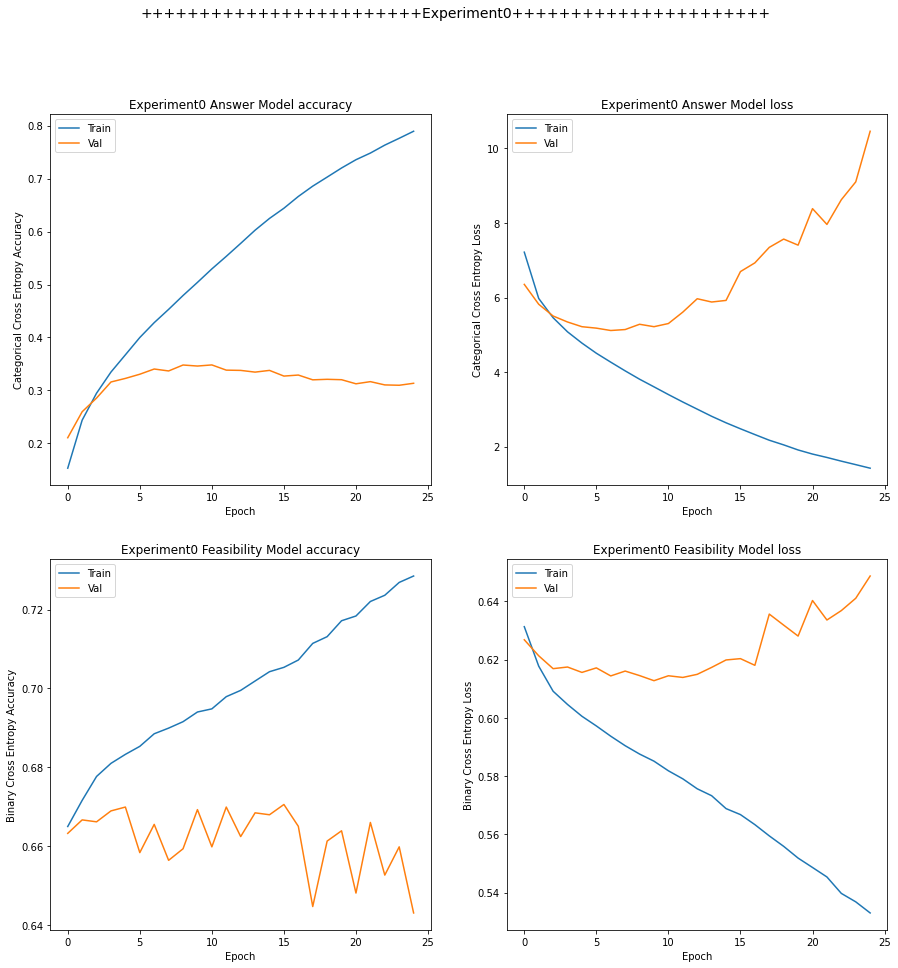

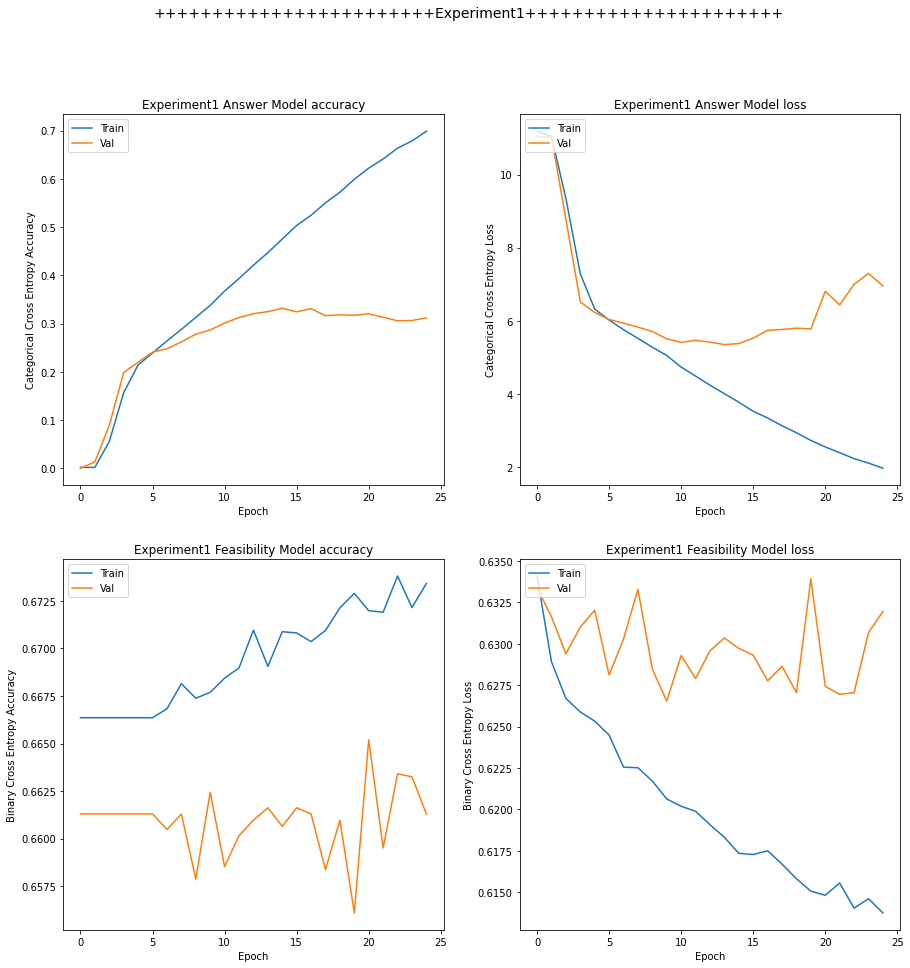

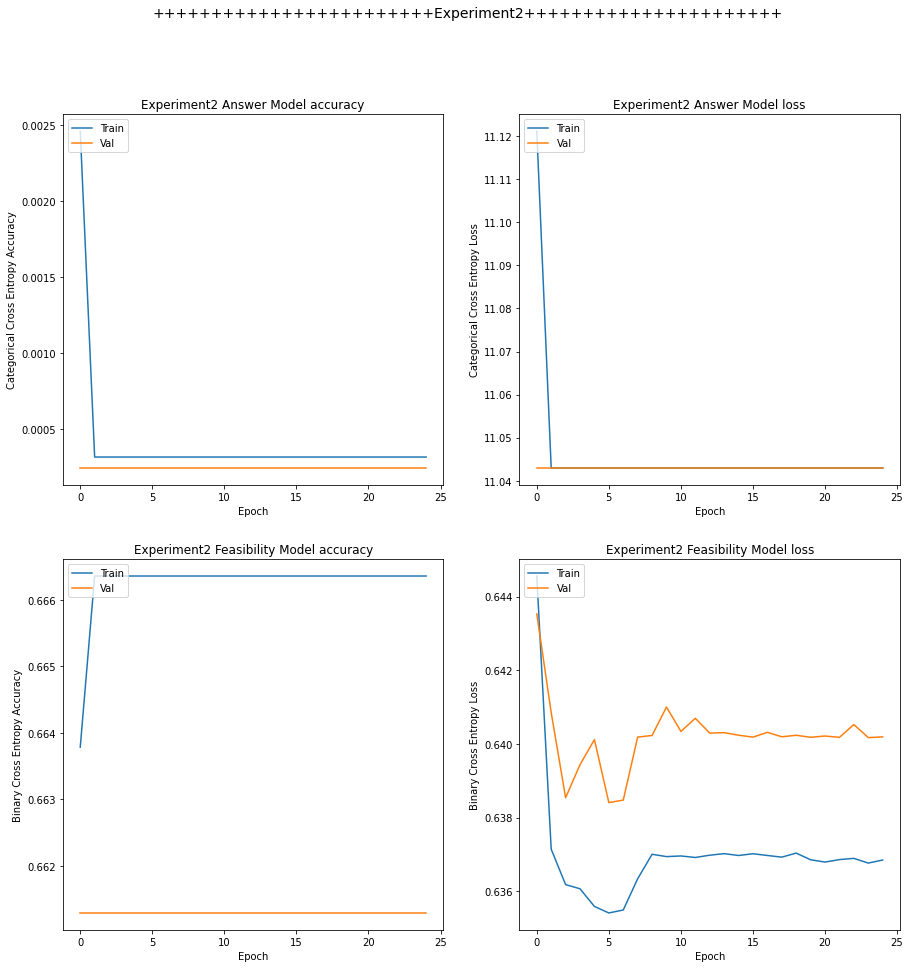

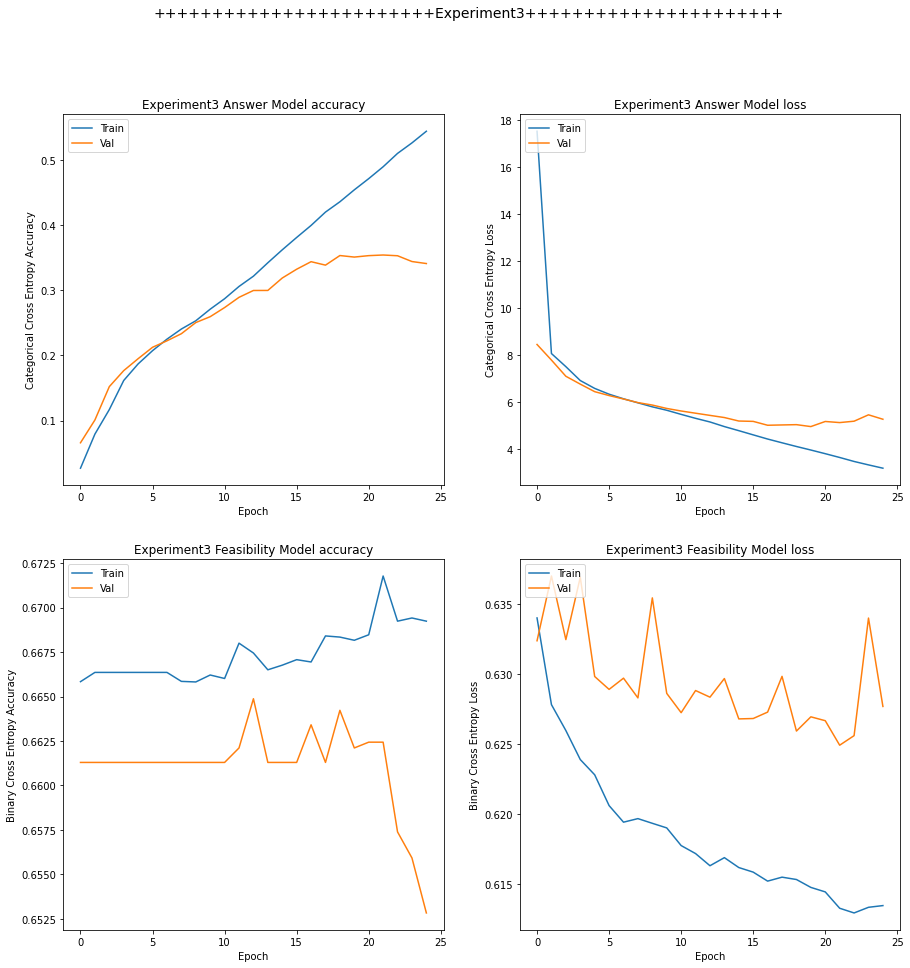

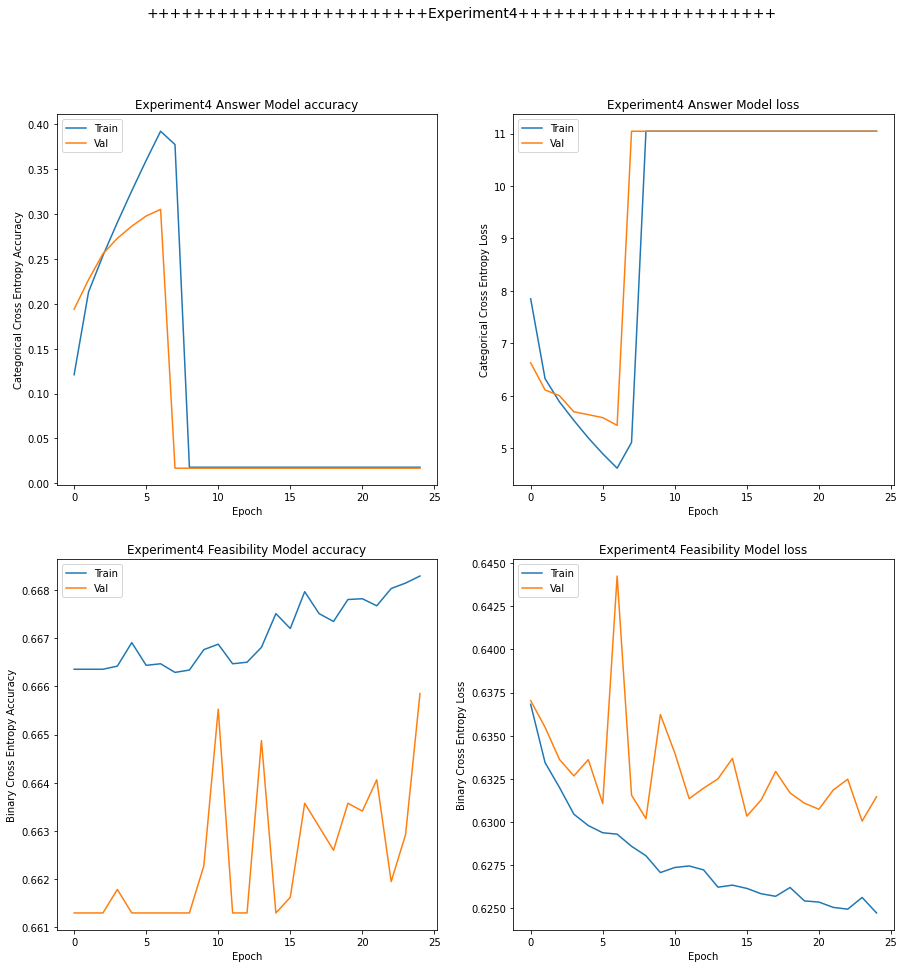

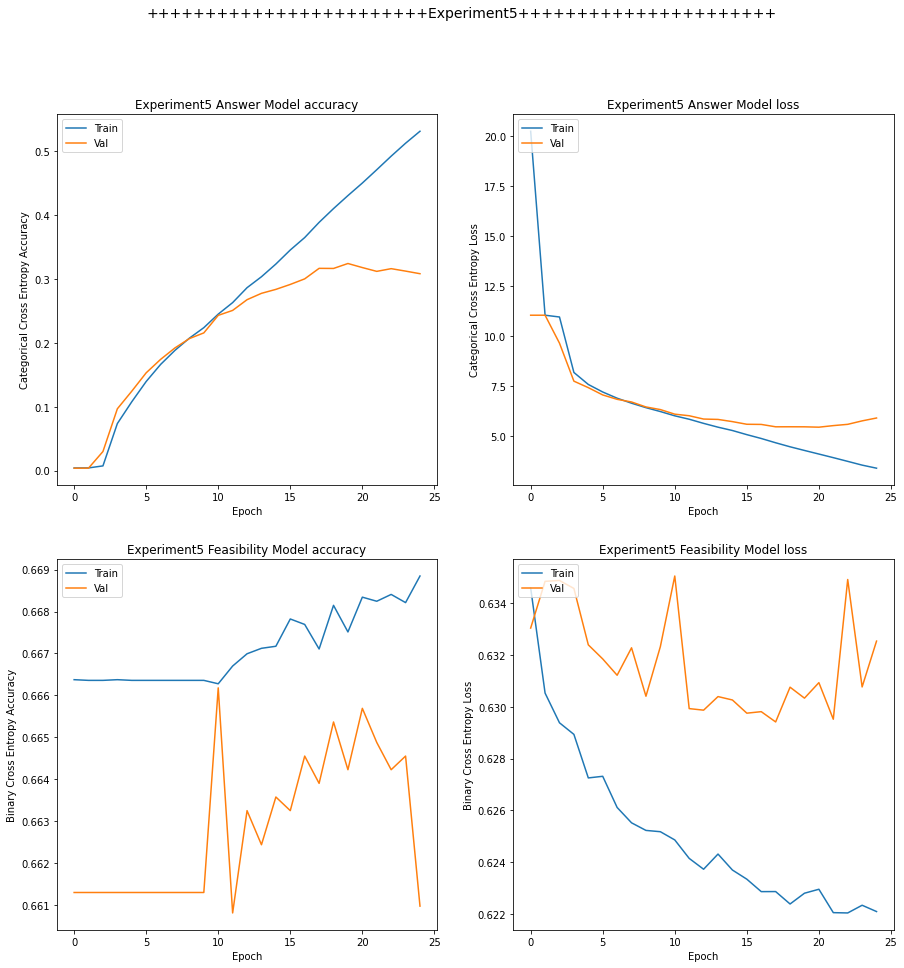

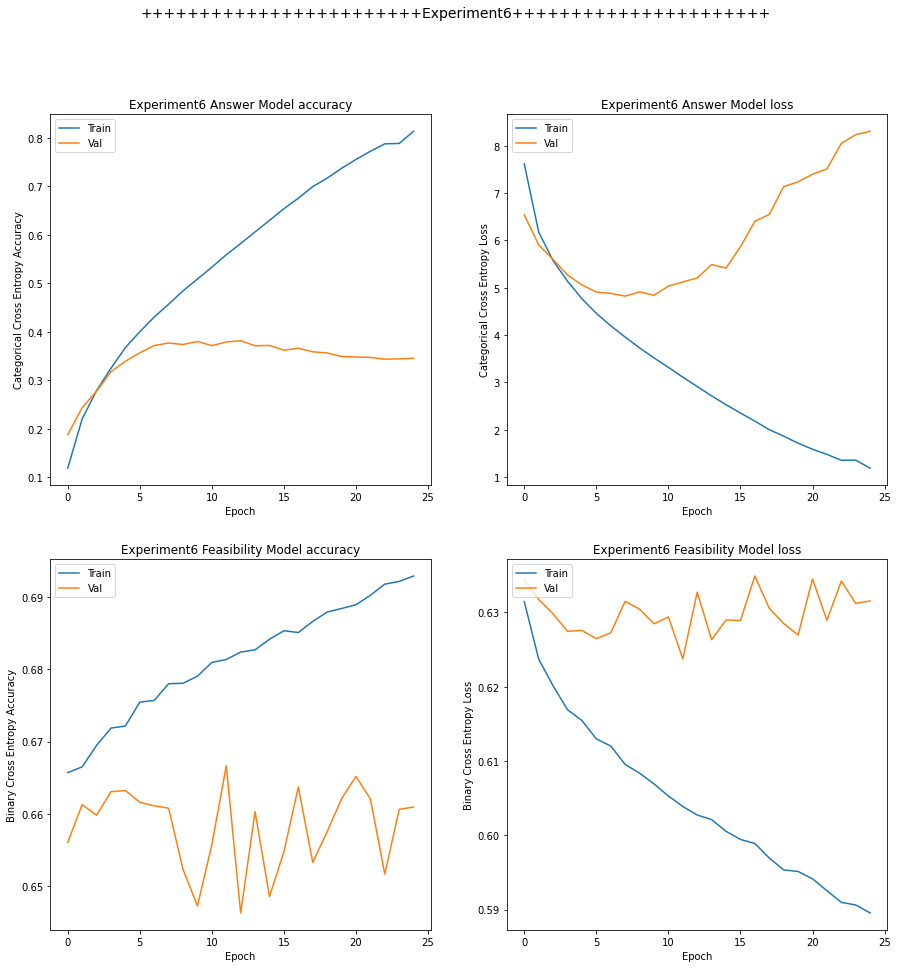

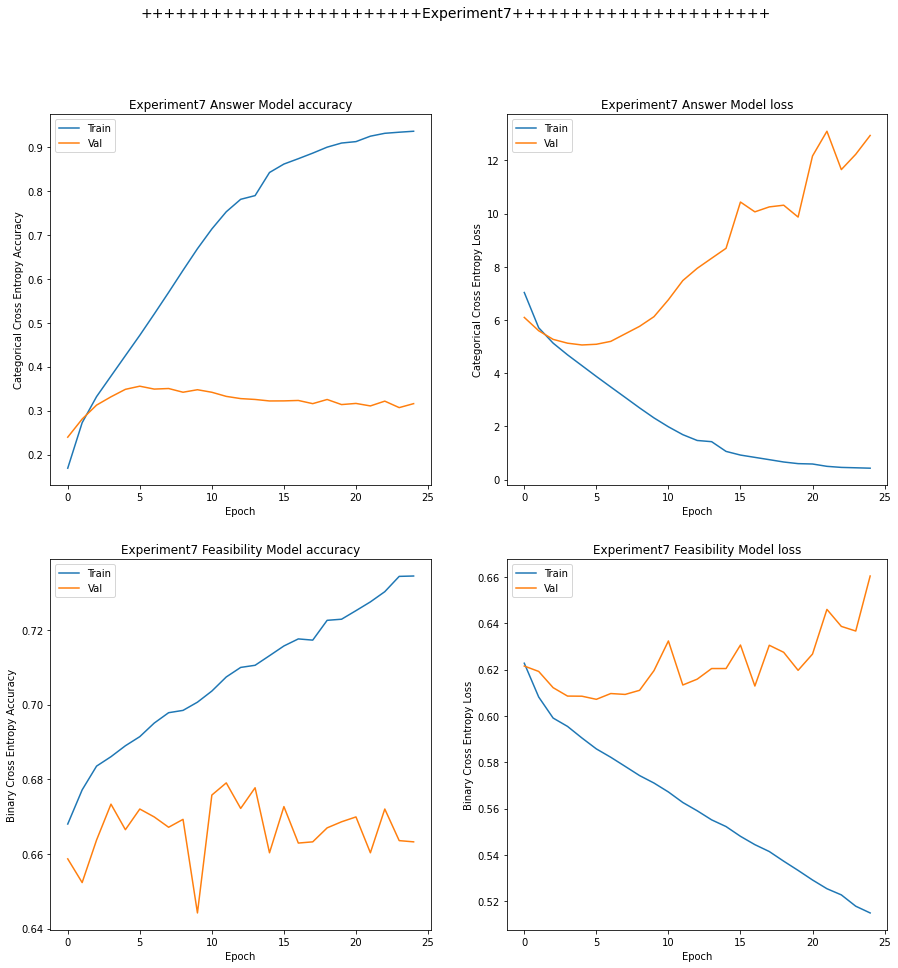

In [15]:
for i in range (8):
    plot_experiments(i)

In [16]:
def plot_experiment_results():
    answer_accuracy_list = []
    feasibility_accuracy_list = []

    for i in range(8):
        
        ExperimentNo = "Experiment"+str(i)
        if ( os.path.exists(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model') 
            and os.path.exists(ExperimentNo+'span_model_LSTM_'+'history_answer_model') ) :
            
            with open(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model', 'rb') as file_history:
                feasibility_history = pickle.load( file_history )

            with open(ExperimentNo+'span_model_LSTM_'+'history_answer_model', 'rb') as file_history:
                answer_history = pickle.load( file_history )

        answer_accuracy_list.append(max(answer_history['val_categorical_accuracy']))
        feasibility_accuracy_list.append(max(feasibility_history['val_binary_accuracy']))

    #plt.plot(answer_accuracy_list,marker='^')
    #plt.plot(feasibility_accuracy_list,marker='*')
    #plt.ylabel("Validation Accuracy")
    #plt.xlabel("Experiment Number")
    #plt.title("LSTM based models experiments result")

    fig, axs = plt.subplots(1, 2,figsize=(15,6))

    #plot Answer Module results
    axs[0].plot(answer_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[0].set_title("LSTM based answer model experiments")
    axs[0].set_ylabel('Validation Accuracy')
    axs[0].set_xlabel('Experiment Number')

    #plot feasibility Module results

    axs[1].plot(feasibility_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[1].set_title("LSTM based feasibility model experiments")
    axs[1].set_ylabel('Validation Accuracy')
    axs[1].set_xlabel('Experiment Number')
    #plt.show()


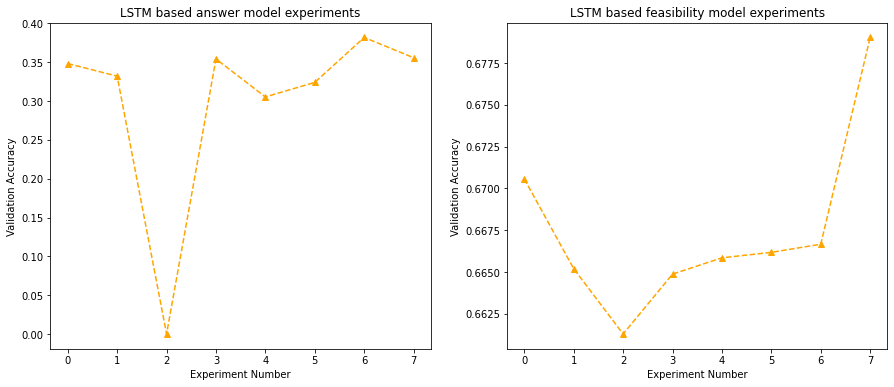

In [17]:
plot_experiment_results()

In [18]:
#create inference models for all the experiments 
for epno in range(8):
    #Create Inference model
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=epno,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)
    #check if the validation file exists 
    ExperimentNo = "Experiment"+str(epno)
    if not os.path.exists(ExperimentNo+'span_model_LSTM_'+'feasibility_val_pred.npy'):
        
        #create validation set for the feasibility module: 
        VAL_BUFFER_SIZE = val_context_padded_seq.shape[0]
        batch_size = 128
        steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size + 1
        val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:VAL_BUFFER_SIZE],
                                                              val_question_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_input_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_target_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_impossible[:VAL_BUFFER_SIZE],
                                                              val_answer_start_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_end_seq_padded[:VAL_BUFFER_SIZE]
                                                             ))
        val_dataset = val_dataset.batch(batch_size,drop_remainder=False)

        i=0
        for (batch, (batch_val_context_padded_seq,
                             batch_val_question_seq_padded,
                             batch_val_answer_seq_padded,
                             batch_val_answer_input_seq_padded,
                             batch_val_answer_target_seq_padded,
                             batch_val_answer_impossible,
                             batch_val_answer_start_seq_padded,
                             batch_val_answer_end_seq_padded)) in tqdm(
                                                    enumerate(val_dataset.take(steps_per_epoch_val)),
                                                    total = VAL_BUFFER_SIZE//batch_size+1,
                                                    desc="[Creating Validation Ferasibility Prediction]"):
            question_output,context_output = inference_encoder_model(batch_val_context_padded_seq,
                                                                   batch_val_context_padded_seq)
            feasibility_pred = inference_feasibility_model([question_output,
                                                            context_output])
            if i==0:
                feasibility_validation_prediction = feasibility_pred.numpy()
            else:
                feasibility_validation_prediction = np.concatenate((feasibility_validation_prediction,
                                                                    feasibility_pred.numpy()),axis=0)
            i += 1
        #save the feasibility_validation_prediction
        np.save(ExperimentNo+'span_model_LSTM_'+'feasibility_val_pred',feasibility_validation_prediction)


[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [22:26<00:06,  6.60s/it]


[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [26:13<00:07,  7.71s/it]


[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [30:53<00:09,  9.09s/it]


In [24]:
#!pip install -U scikit-learn
#!pip install seaborn
from sklearn.metrics import confusion_matrix
import seaborn as sns
""" Following function taken from : 
    https://medium.com/@dtuk81/confusion-matrix-visualization-fc31e3f30fea
"""
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    sns.heatmap(cf,annot=box_labels,fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)


/home/anupj/anaconda3/envs/tensorflow_cpu_2/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: invalid value encountered in long_scalars
/home/anupj/anaconda3/envs/tensorflow_cpu_2/lib/python3.7/site-packages/ipykernel_launcher.py:74: RuntimeWarning: invalid value encountered in double_scalars


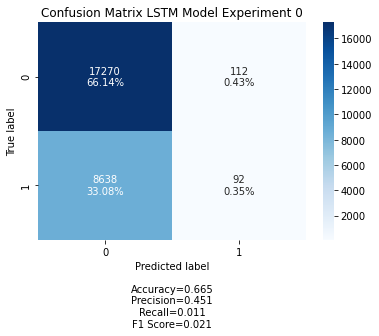

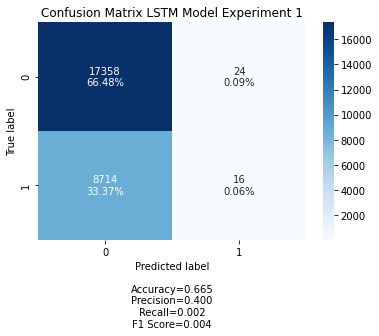

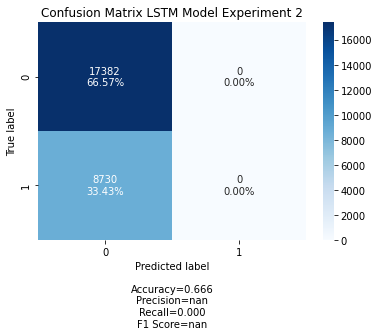

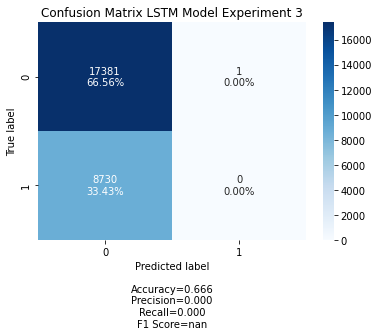

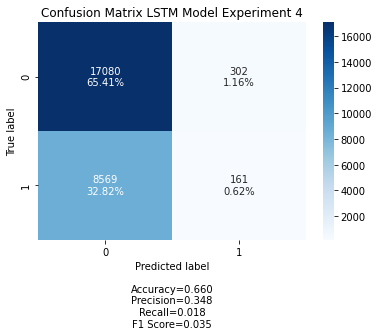

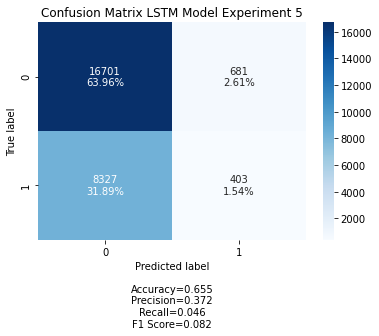

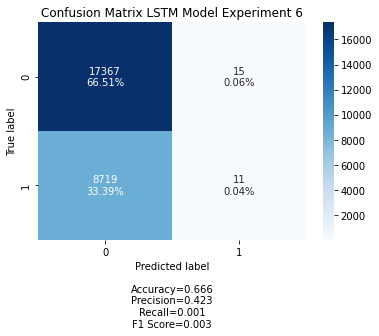

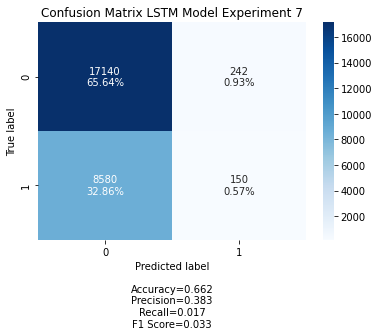

In [28]:
#plot confusion matrix for the feasibility model output for each experiment 

for i in range(8):
    #load feasibility predictions
    ExperimentNo = "Experiment"+str(i)
    if os.path.exists(ExperimentNo+'span_model_LSTM_'+'feasibility_val_pred.npy'):
        y_pred_prob = np.load(ExperimentNo+'span_model_LSTM_'+'feasibility_val_pred.npy')
        y_pred = (y_pred_prob>0.5).astype(int)
        #Get the confusion matrix
        cf_matrix = confusion_matrix(val_answer_impossible, y_pred)
        #print(cf_matrix)
        make_confusion_matrix(cf_matrix,title = 'Confusion Matrix LSTM Model Experiment '+str(i))
        
    

In [59]:
#Function to get sentences from the predicted answers
def decode_sentence_batch(context_input_seq,
                     question_input_seq,
                     encoder_model,
                     answer_model):
    #decoded_sentence = ""
    question_output,context_output = encoder_model(context_input_seq,question_input_seq) 
    
    start_logits,end_logits = answer_model(question_output,context_output)
    
    #Do a outer matrix multiplication of the logits 
    # we need to get the start and end index with highest multiplication of start and end probs
    outer = tf.matmul(tf.expand_dims(start_logits, axis=2),tf.expand_dims(end_logits, axis=1)) 
    outer = tf.linalg.band_part(outer, 0, answer_maxlen)
    start_position = tf.argmax(tf.reduce_max(outer, axis=2),axis=1)    
    end_position = tf.argmax(tf.reduce_max(outer, axis=1),axis=1)
    #start_position = start_position.numpy()
    #end_position = end_position.numpy()
    #print(start_position.shape)
    #print(end_position.shape)
    #print(start_position)
    #print(end_position)
    decoded_sentences_batch = []
    for j in range(question_input_seq.shape[0]):
        decoded_sentence = ''
        for i in range(start_position[j],end_position[j]+1):
            sampled_token_index = context_input_seq[j,i].numpy()
            #print(sampled_token_index)
            if sampled_token_index == 0:
                sampled_char = ""
            else:
                sampled_char = id_vocab[sampled_token_index]
            if i == start_position[j]:
                decoded_sentence += sampled_char
            else:
                decoded_sentence += " "+sampled_char
        decoded_sentences_batch.append(decoded_sentence)
    
    return decoded_sentences_batch

In [60]:
#genarate answers for the questions from the answer model
#create inference models for all the experiments 
for epno in range(8):
    #Create Inference model
    inference_answer_model,\
    inference_encoder_model,\
    inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=epno,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)
    #check if the validation file exists 
    ExperimentNo = "Experiment"+str(epno)
    if ( not os.path.exists(ExperimentNo+'span_model_LSTM_'+'answer_val_pred')
        and os.path.exists(ExperimentNo+'span_model_LSTM_'+'feasibility_val_pred.npy')):
        
        y_pred_prob = np.load(ExperimentNo+'span_model_LSTM_'+'feasibility_val_pred.npy')
        y_pred = (y_pred_prob>0.5).astype(int)
        #create dictionary to store the predicted answer
        val_predicted_answer_dic = {}
        #create list to store the answers
        val_predicted_answer = []
        #create validation set for the feasibility module: 
        VAL_BUFFER_SIZE = val_context_padded_seq.shape[0]
        batch_size = 128
        steps_per_epoch_val = VAL_BUFFER_SIZE//batch_size + 1
        val_dataset = tf.data.Dataset.from_tensor_slices((val_context_padded_seq[:VAL_BUFFER_SIZE],
                                                              val_question_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_input_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_target_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_impossible[:VAL_BUFFER_SIZE],
                                                              val_answer_start_seq_padded[:VAL_BUFFER_SIZE],
                                                              val_answer_end_seq_padded[:VAL_BUFFER_SIZE]
                                                             ))
        val_dataset = val_dataset.batch(batch_size,drop_remainder=False)

        i=0
        for (batch, (batch_val_context_padded_seq,
                             batch_val_question_seq_padded,
                             batch_val_answer_seq_padded,
                             batch_val_answer_input_seq_padded,
                             batch_val_answer_target_seq_padded,
                             batch_val_answer_impossible,
                             batch_val_answer_start_seq_padded,
                             batch_val_answer_end_seq_padded)) in tqdm(
                                                    enumerate(val_dataset.take(steps_per_epoch_val)),
                                                    total = VAL_BUFFER_SIZE//batch_size+1,
                                                    desc="[Creating Validation Ferasibility Prediction]"):
            answers = decode_sentence_batch(batch_val_context_padded_seq,
                                            batch_val_question_seq_padded,
                                            inference_encoder_model,
                                            inference_answer_model)
            val_predicted_answer = val_predicted_answer + answers
        
        for c,(qid,answer) in enumerate(zip(val_qid[:VAL_BUFFER_SIZE],val_predicted_answer)):
            if y_pred[c] == 0 :
                val_predicted_answer_dic[qid] = answer
            else:
                val_predicted_answer_dic[qid] =  ''
        #save the answer_prediction
        with open(ExperimentNo+'span_model_LSTM_'+'answer_val_pred', 'w') as file_answer_prediction:
            file_answer_prediction.write(json.dumps(val_predicted_answer_dic))

[Creating Validation Ferasibility Prediction]: 100%|█████████▉| 204/205 [15:49<00:04,  4.66s/it]


In [67]:
!python evaluate-v2.0.py train-v2.0.json Experiment6span_model_LSTM_answer_val_pred

Traceback (most recent call last):
  File "evaluate-v2.0.py", line 278, in <module>
    main()
  File "evaluate-v2.0.py", line 249, in main
    OPTS.na_prob_thresh)
  File "evaluate-v2.0.py", line 107, in apply_no_ans_threshold
    pred_na = na_probs[qid] > na_prob_thresh
KeyError: '56be85543aeaaa14008c9066'


In [89]:
import argparse
import collections
import json
import numpy as np
import os
import re
import string
import sys
def normalize_answer(s):
       
    """Lower text and remove punctuation, articles and extra whitespace."""
    def remove_articles(text):
        regex = re.compile(r'\b(a|an|the)\b', re.UNICODE)
        return re.sub(regex, ' ', text)
    def white_space_fix(text):
        return ' '.join(text.split())
    def remove_punc(text):
        exclude = set(string.punctuation)
        return ''.join(ch for ch in text if ch not in exclude)
    def lower(text):
        return text.lower()
    
    return white_space_fix(remove_articles(remove_punc(lower(s))))
def get_tokens(s):
    if not s: return []
    return normalize_answer(s).split()

def compute_exact(a_gold, a_pred):
    return int(normalize_answer(a_gold) == normalize_answer(a_pred))


def compute_f1(a_gold, a_pred):
    gold_toks = get_tokens(a_gold)
    pred_toks = get_tokens(a_pred)
    common = collections.Counter(gold_toks) & collections.Counter(pred_toks)
    num_same = sum(common.values())
    if len(gold_toks) == 0 or len(pred_toks) == 0:
        # If either is no-answer, then F1 is 1 if they agree, 0 otherwise
        return int(gold_toks == pred_toks)
    if num_same == 0:
        return 0
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
    return f1

def get_raw_scores(dataset, preds,only_answerable_questions):
    exact_scores = {}
    f1_scores = {}
    for article in dataset:
        for p in article['paragraphs']:
            for qa in p['qas']:
                qid = qa['id']
                gold_answers = [a['text'] for a in qa['answers']
                                if normalize_answer(a['text'])]
                if gold_answers or not only_answerable_questions:
                    if not gold_answers:
                        # For unanswerable questions, only correct answer is empty string
                        gold_answers = ['']
                    if qid not in preds:
                        #print('Missing prediction for %s' % qid)
                        continue
                    a_pred = preds[qid]
                    # Take max over all gold answers
                    exact_scores[qid] = max(compute_exact(a, a_pred) for a in gold_answers)
                    f1_scores[qid] = max(compute_f1(a, a_pred) for a in gold_answers)
    return exact_scores, f1_scores

def calculate_f1(dataset_file_name,prediction_file_name,only_answerable_questions=False):
    with open(dataset_file_name) as f:
        dataset_json = json.load(f)
        dataset = dataset_json['data']
    with open(prediction_file_name) as f:
        preds = json.load(f)
    exact_raw, f1_raw = get_raw_scores(dataset, preds,only_answerable_questions)
    total = len(exact_raw)
    return collections.OrderedDict([
                                    ('exact', 100.0 * sum(exact_raw.values()) / total),
                                    ('f1', 100.0 * sum(f1_raw.values()) / total),
                                    ('total', total),
                                   ])
    #return exact_raw, f1_raw

In [92]:
g1 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'Experiment6span_model_LSTM_answer_val_pred',
                 only_answerable_questions=True)
g2 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'Experiment6span_model_LSTM_answer_val_pred',
                 only_answerable_questions=False)

In [93]:
g2

OrderedDict([('exact', 19.53125), ('f1', 28.41886663608186), ('total', 26112)])

In [88]:
f1_score = []
f1_score_only_answerable = []
for epno in range(8):
    ExperimentNo = "Experiment"+str(epno)
    g1 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'Experiment6span_model_LSTM_answer_val_pred',
                 only_answerable_questions=True)
    g2 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = 'Experiment6span_model_LSTM_answer_val_pred',
                 only_answerable_questions=False)
    f1_score.append(g1['f1'])
    f1_score_only_answerable.append(g2['f1'])


    
                        

OrderedDict([('exact', 19.53125), ('f1', 28.41886663608186), ('total', 26112)])

In [104]:
def plot_experiment_results_all():
    answer_accuracy_list = []
    feasibility_accuracy_list = []
    f1_score = []
    f1_score_only_answerable = []
    for i in range(8):
        
        ExperimentNo = "Experiment"+str(i)
        if ( os.path.exists(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model') 
            and os.path.exists(ExperimentNo+'span_model_LSTM_'+'history_answer_model') ) :
            
            with open(ExperimentNo+'span_model_LSTM_'+'history_feasibility_model', 'rb') as file_history:
                feasibility_history = pickle.load( file_history )

            with open(ExperimentNo+'span_model_LSTM_'+'history_answer_model', 'rb') as file_history:
                answer_history = pickle.load( file_history )

        answer_accuracy_list.append(max(answer_history['val_categorical_accuracy']))
        feasibility_accuracy_list.append(max(feasibility_history['val_binary_accuracy']))
        g1 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = ExperimentNo+'span_model_LSTM_answer_val_pred',
                 only_answerable_questions=True)
        g2 = calculate_f1(dataset_file_name = 'train-v2.0.json', 
                 prediction_file_name = ExperimentNo+'span_model_LSTM_answer_val_pred',
                 only_answerable_questions=False)
        f1_score.append(g2['f1'])
        f1_score_only_answerable.append(g1['f1'])

    #plt.plot(answer_accuracy_list,marker='^')
    #plt.plot(feasibility_accuracy_list,marker='*')
    #plt.ylabel("Validation Accuracy")
    #plt.xlabel("Experiment Number")
    #plt.title("LSTM based models experiments result")

    fig, axs = plt.subplots(1, 3,figsize=(15,6))

    #plot Answer Module results
    axs[0].plot(answer_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[0].set_title("LSTM based answer model experiments")
    axs[0].set_ylabel('Validation Accuracy')
    axs[0].set_xlabel('Experiment Number')

    #plot feasibility Module results

    axs[1].plot(feasibility_accuracy_list,marker='^',linestyle='dashed',color='orange')
    axs[1].set_title("LSTM based feasibility model experiments")
    axs[1].set_ylabel('Validation Accuracy')
    axs[1].set_xlabel('Experiment Number')
    #plt.show()
    axs[2].plot(f1_score,marker='^',linestyle='dashed',color='orange')
    axs[2].plot(f1_score_only_answerable,marker='o',linestyle='dashed',color='blue')
    axs[2].legend(['All Qtns', 'Only Answerable Qtns'], loc='lower right')
    axs[2].set_title("LSTM based model F1 Score")
    axs[2].set_ylabel('Validation F1 Score')
    axs[2].set_xlabel('Experiment Number')
    


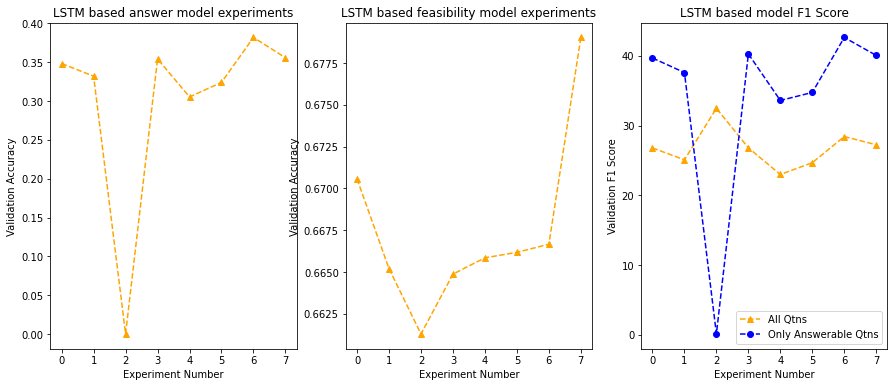

In [105]:
plot_experiment_results_all()

In [120]:
#Some examples from validation set from experiment6
with open('Experiment6span_model_LSTM_answer_val_pred') as f:
    k = json.load(f)
for seq_index in range(100,132):
    # Take one sequence (part of the Validation test)
    # for trying out decoding.
    qid = val_qid[seq_index]
    question = ' '.join([id_vocab.get(i) for i in val_question_seq_padded[seq_index].tolist() if i !=0])
    act_answer = ' '.join([id_vocab.get(i) for i in val_answer_input_seq_padded[seq_index].tolist() if i !=0])
    print(qid,': ',question,'?')
    print('Actual Answer: ',act_answer) 
    print('Predicted Answer: ',k[qid])
    
    
    

57290895af94a219006a9fae :  what is france s oldest operating news agency ?
Actual Answer:  agence
Predicted Answer:  france presse
5acd745d07355d001abf4310 :  how do people most often get to strasbourg from elsewhere ?
Actual Answer:  
Predicted Answer:  run through the centre
5acda11d07355d001abf487e :  what state was the fourth highest percentage of housing related costs in the country ?
Actual Answer:  
Predicted Answer:  us census bureau
5725b58fec44d21400f3d41b :  who did the jewish inhabitants fight side by side with ?
Actual Answer:  fatimid garrison
Predicted Answer:  fatimid garrison
570da87816d0071400510c5e :  what events have occurred in recent decades to the ice shelves surrounding antarctica ?
Actual Answer:  collapses
Predicted Answer:  ice shelves may
571a6bf110f8ca1400305014 :  what age can an infabt recall steps in an order ?
Actual Answer:  9 months of age
Predicted Answer:  9 months of age
56df6e4a5ca0a614008f9a1a :  how many members does the “group of 77” have ?
Ac

In [123]:
#Final Prediction 
dev_lists = get_c_q_a(dev_pd)

def vectorize_data_dev_set(tokenizer_obj,dev_lists):
    qid_original = dev_lists[0]
    context_seq = tokenizer_obj.texts_to_sequences(dev_lists[1])
    question_seq = tokenizer_obj.texts_to_sequences(dev_lists[2])
    context_seq_padded = pad_sequences(context_seq,context_maxlen,padding='post', truncating='post')
    #Adding 0 to last position special for no answer questions
    #context_seq_padded = pad_sequences(context_seq_padded,context_maxlen,padding='post', truncating='post')
    question_seq_padded = pad_sequences(question_seq,question_maxlen,padding='post', truncating='post')
    answer_impossible = np.array(dev_lists[3])
    #indices = np.arange(context_seq_padded.shape[0])
    #np.random.seed(19)
    #np.random.shuffle(indices)
    qid = qid_original
    #context_seq_padded = context_seq_padded[indices]
    #question_seq_padded = question_seq_padded[indices]
    dev_qid = qid
    dev_context_padded_seq = context_seq_padded
    dev_question_seq_padded = question_seq_padded
    dev_answer_impossible = answer_impossible
    return (dev_qid,dev_context_padded_seq,dev_question_seq_padded,dev_answer_impossible)

dev_qid,\
dev_context_padded_seq,\
dev_question_seq_padded,\
dev_answer_impossible = vectorize_data_dev_set(tokenizer_obj,dev_lists)
print("dev num samples where answer impossible: ",len(dev_question_seq_padded[dev_answer_impossible==1]))
print("dev num samples where answer not impossible: ",len(dev_question_seq_padded[dev_answer_impossible==0]))

dev num samples where answer impossible:  5945
dev num samples where answer not impossible:  5928


In [125]:
#create dev set results using experiment 6
#Create Inference model
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=6,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)
        
#create validation set for the feasibility module: 
DEV_BUFFER_SIZE = dev_context_padded_seq.shape[0]
batch_size = 128
steps_per_epoch_val = DEV_BUFFER_SIZE//batch_size + 1
dev_dataset = tf.data.Dataset.from_tensor_slices((dev_context_padded_seq[:DEV_BUFFER_SIZE],
                                                      dev_question_seq_padded[:DEV_BUFFER_SIZE],
                                                      dev_answer_impossible[:DEV_BUFFER_SIZE]
                                                     ))
dev_dataset = dev_dataset.batch(batch_size,drop_remainder=False)

i=0
dev_predicted_answer_dic = {}
#create list to store the answers
dev_predicted_answer = []
for (batch, (batch_dev_context_padded_seq,
             batch_dev_question_seq_padded,
             batch_dev_answer_impossible )) in tqdm(
                                            enumerate(dev_dataset.take(steps_per_epoch_val)),
                                            total = DEV_BUFFER_SIZE//batch_size+1,
                                            desc="[Creating Dev Set Prediction]"):
    question_output,context_output = inference_encoder_model(batch_dev_context_padded_seq,
                                                           batch_dev_context_padded_seq)
    feasibility_pred = inference_feasibility_model([question_output,
                                                    context_output])
    answers = decode_sentence_batch(batch_dev_context_padded_seq,
                                    batch_dev_question_seq_padded,
                                    inference_encoder_model,
                                    inference_answer_model)
    dev_predicted_answer = dev_predicted_answer + answers
    if i==0:
        feasibility_validation_prediction = feasibility_pred.numpy()
    else:
        feasibility_validation_prediction = np.concatenate((feasibility_validation_prediction,
                                                            feasibility_pred.numpy()),axis=0)
    i += 1

    
#save the feasibility_validation_prediction
np.save('Final_span_model_LSTM_'+'feasibility_dev_pred',feasibility_validation_prediction)
y_pred = (feasibility_validation_prediction>0.5).astype(int)
for c,(qid,answer) in enumerate(zip(dev_qid[:DEV_BUFFER_SIZE],dev_predicted_answer)):
    if y_pred[c] == 0 :
        dev_predicted_answer_dic[qid] = answer
    else:
        dev_predicted_answer_dic[qid] =  ''
#save the answer_prediction
with open('Final_span_model_LSTM_'+'answer_dev_pred', 'w') as file_answer_prediction:
    file_answer_prediction.write(json.dumps(dev_predicted_answer_dic))

[Creating Dev Set Prediction]: 100%|██████████| 93/93 [26:35<00:00, 17.16s/it]


In [126]:
!python evaluate-v2.0.py dev-v2.0.json Final_span_model_LSTM_answer_dev_pred

{
  "exact": 13.172744883348775,
  "f1": 20.05142053922549,
  "total": 11873,
  "HasAns_exact": 26.248313090418353,
  "HasAns_f1": 40.025390698755785,
  "HasAns_total": 5928,
  "NoAns_exact": 0.1345668629100084,
  "NoAns_f1": 0.1345668629100084,
  "NoAns_total": 5945
}


In [127]:
#Check if our own f1 score caculation matches the formal evaluation script
g1 = calculate_f1(dataset_file_name = 'dev-v2.0.json', 
                 prediction_file_name = 'Final_span_model_LSTM_answer_dev_pred',
                 only_answerable_questions=True)
g2 = calculate_f1(dataset_file_name = 'dev-v2.0.json', 
                 prediction_file_name = 'Final_span_model_LSTM_answer_dev_pred',
                 only_answerable_questions=False)

print(g1)

print(g2)

OrderedDict([('exact', 26.248313090418353), ('f1', 40.025390698755785), ('total', 5928)])
OrderedDict([('exact', 13.172744883348775), ('f1', 20.05142053922549), ('total', 11873)])


In [132]:
#Remove <unk> from the predictions
!sed 's/<unk>//g' Final_span_model_LSTM_answer_dev_pred > Final_span_model_LSTM_answer_dev_pred_without_unk

In [133]:
!python evaluate-v2.0.py dev-v2.0.json Final_span_model_LSTM_answer_dev_pred_without_unk

{
  "exact": 16.12060978691148,
  "f1": 23.197687331780553,
  "total": 11873,
  "HasAns_exact": 26.467611336032387,
  "HasAns_f1": 40.64206168863548,
  "HasAns_total": 5928,
  "NoAns_exact": 5.8031959629941126,
  "NoAns_f1": 5.8031959629941126,
  "NoAns_total": 5945
}


In [22]:
inference_answer_model,\
inference_encoder_model,\
inference_feasibility_model = create_inference_model(Experiment_Dic=Experiment_Dic,
                                                     Experiment_No=6,
                                                     embedding_matrix=embedding_matrix,
                                                     ndim = ndim)




In [30]:
para = "Chitra and Anup are studying natural language processing with deep learning at \
University of Berkeley in Data Science course. The course is being taught by Mark Butler. They are working \
on a project using dynamic memory network for \
question and answering. They find that even though dynamic memory network is good for some old data sets it \
does not perform that well with open domain questions. They had fun time in creating the neural models from \
scratch as they did not use transfer learning. Even though they did not get state of the art results on their \
original dataset they learnt a lot."
synthetic_context_list = [para,para,para,para,para,para]
synthetic_question_list = ["Which class are Chitra and Anup taking ?",
                           "What does the project use? ",
                           "Who is teaching the class ?",
                           "What did they not use ?",
                           "Which university are they studying in ?",
                           "When was Isaac Newton Born ?"]

synthetic_context_seq = tokenizer_obj.texts_to_sequences(synthetic_context_list)
synthetic_question_seq = tokenizer_obj.texts_to_sequences(synthetic_question_list)
syntehtic_context_seq_padded = pad_sequences(synthetic_context_seq,context_maxlen,
                                             padding='post', truncating='post')
synthetic_question_seq_padded = pad_sequences(synthetic_question_seq,question_maxlen,
                                              padding='post', truncating='post')
print("++++++++++++++ Paragraph ++++++++++++++++++")
print(para)
print("++++++++++++++ Paragraph ++++++++++++++++++")
for seq_index in range(6):
    # Take one sequence (part of the Validation test)
    # for trying out decoding.
    context_input_seq = syntehtic_context_seq_padded[seq_index: seq_index+ 1]
    question_input_seq = synthetic_question_seq_padded[seq_index: seq_index + 1]
    decoded_sentence = decode_sentence(context_input_seq,
                                       question_input_seq,
                                       inference_encoder_model,
                                       inference_answer_model)
    question_output,context_output = inference_encoder_model(context_input_seq,question_input_seq)
    #start_logits,end_logits = inference_answer_model(question_output,context_output)         
    feasibility_pred = inference_feasibility_model.predict([question_output,
                                                            context_output])
    print("question:",synthetic_question_list[seq_index])
    print("Probability of Question Infeasible to answer:",feasibility_pred)
    print('Predicted Answer:', decoded_sentence)

++++++++++++++ Paragraph ++++++++++++++++++
Chitra and Anup are studying natural language processing with deep learning at University of Berkeley in Data Science course. The course is being taught by Mark Butler. They are working on a project using dynamic memory network for question and answering. They find that even though dynamic memory network is good for some old data sets it does not perform that well with open domain questions. They had fun time in creating the neural models from scratch as they did not use transfer learning. Even though they did not get state of the art results on their original dataset they learnt a lot.
++++++++++++++ Paragraph ++++++++++++++++++
question: Which class are Chitra and Anup taking ?
Probability of Question Infeasible to answer: [[0.43237454]]
Predicted Answer: natural language processing with deep learning
question: What does the project use? 
Probability of Question Infeasible to answer: [[0.38325807]]
Predicted Answer: dynamic memory network
q